In [2]:
!pip install gym

In [3]:
import gym
from gym import spaces
import numpy as np

In [ ]:
class CompressorEnv(gym.Env):
  def __init__(self):
    super(CompressorEnv, self).__init__()
    # (State Space):[Q_in, P_in, T_in, R_C, N]
    self.observation_space = spaces.Box(low=np.array([0, 1, 273, 1, 500]),
                                        high=np.array([100, 10, 373, 5, 2000]),
                                        dtype=np.float32)
    # (Action Space) = delta
    self.action_space = spaces.Box(low=np.array([-10, -1, - 0.1, -50]),
                                   high=np.array([10, 1, 0.1, 50]),
                                   dtype=np.float32)
    self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0]) # [ Q_IN, P_IN, T_IN, R_C, N]
    self.gamma = 1.4
    self.cp = 1000.0

  def reset(self):
    self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
    return self.state

  def step(self, action):
    Q_in, P_in,  T_in, R_C, N = self.state
    delta_Q_in, delta_P_in, delta_R_C, delta_N = action

    Q_in += delta_Q_in
    P_in += delta_P_in
    R_C += delta_R_C
    N += delta_N

    Q_in = np.clip(Q_in, 0, 100)
    P_in = np.clip(P_in, 1, 10)
    R_C = np.clip(R_C, 1, 5)
    N = np.clip(N, 500, 2000)


    P_out = P_in * R_C
    T_out = T_in * (R_C ** (self.gamma - 1) / self.gamma)
    energy_consumption = Q_in * self.cp * (T_out - T_in)
    efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

    self.state = np.array([Q_in, P_in,  T_in, R_C, N])

    reward = efficiency - (energy_consumption / 1e6) - abs(T_out - 350)

    done = False

    if efficiency < 0.1 or energy_consumption > 1e6:
      done = True

    return self.state, reward, done, {}

In [5]:
!pip install shimmy

In [4]:
!pip install stable_baselines3

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# ایجاد محیط
env = CompressorEnv()

# بررسی صحت محیط
# check_env(env)

# ایجاد مدل PPO
model = PPO("MlpPolicy", env, verbose=1)

# آموزش مدل
model.learn(total_timesteps=100000)

# ذخیره مدل
model.save("compressor_optimization_model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -19      |
| time/              |          |
|    fps             | 510      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | -17.1      |
| time/                   |            |
|    fps                  | 334        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.17085129 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.6

KeyboardInterrupt: 

In [ ]:
import time

# بارگذاری مدل
model = PPO.load("compressor_optimization_model")

# تست مدل
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(f"Step {i}: State={obs}, '\t'Reward={reward}")
    if done:
        obs = env.reset()
    time.sleep(0.1)

Step 0: State=[  43.8838048     1.33652824  300.            3.1        1000.2861152 ], '	'Reward=-14.691951453277335
Step 1: State=[  43.87018442    2.          300.            3.1        1000.08182021], '	'Reward=-14.691447611075848
Step 2: State=[ 44.01420784   1.60686284 300.           3.1        999.70155483], '	'Reward=-14.696766712855284
Step 3: State=[4.39248829e+01 1.00000000e+00 3.00000000e+02 3.10000000e+00
 1.00124758e+03], '	'Reward=-14.693468847569495
Step 4: State=[  43.89135265    1.15047136  300.            3.1        1000.87116963], '	'Reward=-14.692230426478885
Step 5: State=[ 43.97965574   1.69857353 300.           3.1        999.57766029], '	'Reward=-14.695490631543233
Step 6: State=[4.39504676e+01 1.00000000e+00 3.00000000e+02 3.10000000e+00
 1.00087406e+03], '	'Reward=-14.69441365577383
Step 7: State=[ 43.8990159    1.07957639 300.           3.1        999.34122252], '	'Reward=-14.692513511783272
Step 8: State=[ 43.92398024   1.         300.           3.1        9

In [ ]:
import numpy as np
import gym
from gym import spaces

class CompressorEnv(gym.Env):
    def __init__(self):
        super(CompressorEnv, self).__init__()

        # فضای حالت (State Space): [Q_in, P_in, T_in, R_c, N]
        self.observation_space = spaces.Box(low=np.array([0, 1, 273, 1, 500]),
                                            high=np.array([100, 10, 373, 5, 2000]),
                                            dtype=np.float32)

        # فضای عمل (Action Space): [ΔQ_in, ΔP_in, ΔR_c, ΔN]
        self.action_space = spaces.Box(low=np.array([-10, -1, -0.1, -50]),
                                       high=np.array([10, 1, 0.1, 50]),
                                       dtype=np.float32)

        # پارامترهای اولیه
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0]) # [Q_in, P_in, T_in, R_c, N]
        self.gamma = 1.4 # نسبت ظرفیت‌های خاص گاز
        self.cp = 1000.0 # گرمای مخصوص ثابت فشار (J/kg.K)

    def reset(self):
        # بازنشانی حالت به حالت اولیه
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
        return self.state

    def step(self, action):
        # اعمال عمل به حالت فعلی
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # بروزرسانی پارامترها
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # محدود کردن مقادیر در بازه مجاز
        Q_in = np.clip(Q_in, 0, 100)
        P_in = np.clip(P_in, 1, 10)
        R_c = np.clip(R_c, 1, 5)
        N = np.clip(N, 500, 2000)

        # محاسبه خروجی‌ها
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # به روز رسانی حالت
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # تعریف تابع جایزه
        reward = efficiency - (energy_consumption / 1e6) - abs(T_out - 350) # بهینه‌سازی کارایی و دما

        # تشخیص پایان اپیزود
        done = False
        if efficiency < 0.1 or energy_consumption > 1e6:
            done = True

        info = {}  # اضافه کردن info برای رفع خطا
        return self.state, reward, done, info

# Genetic Algorithm Implementation
def genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.1):
    # Define the bounds for actions
    action_low = env.action_space.low
    action_high = env.action_space.high

    # Initialize population
    population = np.random.uniform(action_low, action_high, (population_size, len(action_low)))

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            obs = env.reset()
            total_reward = 0
            done = False

            while not done:
                obs, reward, done, _ = env.step(individual)
                total_reward += reward

            fitness_scores.append(total_reward)

        # Print the best fitness score in this generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness}")

        # Select parents based on fitness scores
        probabilities = np.array(fitness_scores) / sum(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] = np.random.uniform(action_low[mutation_index], action_high[mutation_index])

        # Replace population with offspring
        population = np.array(offspring)

    # Return the best individual
    best_index = np.argmax(fitness_scores)
    return population[best_index]


# Run Genetic Algorithm
env = CompressorEnv()
best_action = genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.1)

# Print the result in a user-friendly format
print(f"ΔQ_in = {best_action[0]:.4f}")
print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(best_action[0]):.2f} واحد {'افزایش' if best_action[0] > 0 else 'کاهش'} دهید.\n")

print(f"ΔP_in = {best_action[1]:.4f}")
print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
print(f"به این معنی که فشار ورودی را باید حدوداً {abs(best_action[1]):.2f} واحد {'افزایش' if best_action[1] > 0 else 'کاهش'} دهید.\n")

print(f"ΔR_c = {best_action[2]:.4f}")
print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
print(f"به این معنی که نسبت فشار را باید حدوداً {abs(best_action[2]):.2f} واحد {'افزایش' if best_action[2] > 0 else 'کاهش'} دهید.\n")

print(f"ΔN = {best_action[3]:.4f}")
print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(best_action[3]):.2f} واحد {'افزایش' if best_action[3] > 0 else 'کاهش'} دهید.")

Generation 0: Best Fitness = -62.72716288008888
Generation 1: Best Fitness = -62.3669522190951
Generation 2: Best Fitness = -62.44131660114112
Generation 3: Best Fitness = -63.33116692979679
Generation 4: Best Fitness = -63.21348685302088
Generation 5: Best Fitness = -62.17952063942792
Generation 6: Best Fitness = -62.17952063942792
Generation 7: Best Fitness = -62.17952063942792
Generation 8: Best Fitness = -62.17952063942792
Generation 9: Best Fitness = -61.932762672826684
Generation 10: Best Fitness = -62.17952063942792
Generation 11: Best Fitness = -62.59819584215296
Generation 12: Best Fitness = -62.59819584215296
Generation 13: Best Fitness = -62.598195534594105
Generation 14: Best Fitness = -62.598195534594105
Generation 15: Best Fitness = -62.59819584215296
Generation 16: Best Fitness = -65.47946089247432
Generation 17: Best Fitness = -67.06315199833301
Generation 18: Best Fitness = -64.50177691294137
Generation 19: Best Fitness = -64.50177691294137
Generation 20: Best Fitness 

In [ ]:
class CompressorSimulator:
    def __init__(self, env, model):
        """
        Initialize the simulator.
        :param env: The compressor environment (CompressorEnv).
        :param model: A pre-trained model (e.g., genetic algorithm or RL model).
        """
        self.env = env
        self.model = model

    def generate_data(self, num_samples=1000000):
        """
        Generate sensor data for the compressor system.
        :param num_samples: Number of data points to generate.
        :return: List of states and corresponding actions.
        """
        states = []
        actions = []

        obs = self.env.reset()
        for _ in range(num_samples):
            # Predict action using the model
            action, _ = self.model.predict(obs)

            # Store the current state and predicted action
            states.append(obs)
            actions.append(action)

            # Step the environment
            obs, _, done, _ = self.env.step(action)
            if done:
                obs = self.env.reset()

        return np.array(states), np.array(actions)

    def simulate_real_time(self, num_steps=100):
        """
        Simulate the compressor system in real-time and display outputs.
        :param num_steps: Number of steps to simulate.
        """
        obs = self.env.reset()
        for step in range(num_steps):
            # Predict action using the model
            action, _ = self.model.predict(obs)

            # Step the environment
            obs, reward, done, _ = self.env.step(action)

            # Display the results
            print(f"Step {step + 1}:")
            print(f"  State: {obs}")
            print(f"  Predicted Action: {action}")
            print(f"  Reward: {reward:.4f}\n")

            if done:
                obs = self.env.reset()


# Example Usage
if __name__ == "__main__":
    # Create the environment
    env = CompressorEnv()

    # Load your pre-trained model (replace this with your actual model)
    from stable_baselines3 import PPO
    model = PPO.load("compressor_optimization_model")

    # Create the simulator
    simulator = CompressorSimulator(env, model)

    # Generate 1,000,000 data points
    print("Generating 1,000,000 data points...")
    states, actions = simulator.generate_data(num_samples=1000000)
    print("Data generation complete.")

    # Simulate in real-time for 100 steps
    print("\nSimulating in real-time for 100 steps:")
    simulator.simulate_real_time(num_steps=100)

Generating 1,000,000 data points...
Data generation complete.

Simulating in real-time for 100 steps:
Step 1:
  State: [ 43.96978712   1.20782398 300.           3.1        999.04325634]
  Predicted Action: [-6.030213    0.20782398  0.1        -0.95674366]
  Reward: -69.5204

Step 2:
  State: [  43.92019701    1.32110226  300.            3.1        1000.02205462]
  Predicted Action: [-6.079803    0.32110226  0.1         0.02205462]
  Reward: -69.5147

Step 3:
  State: [ 43.92714739   1.         300.           3.1        999.09252083]
  Predicted Action: [-6.0728526  -1.          0.1        -0.90747917]
  Reward: -69.5155

Step 4:
  State: [4.39456983e+01 1.00000000e+00 3.00000000e+02 3.10000000e+00
 1.00093182e+03]
  Predicted Action: [-6.0543017  -0.10602164  0.1         0.9318199 ]
  Reward: -69.5176

Step 5:
  State: [ 43.85265446   1.         300.           3.1        999.59847495]
  Predicted Action: [-6.1473455  -0.12315427  0.1        -0.40152505]
  Reward: -69.5070

Step 6:
  St

In [ ]:
class CompressorSimulator:
    def __init__(self, env, model):
        """
        Initialize the simulator.
        :param env: The compressor environment (CompressorEnv).
        :param model: A pre-trained model (e.g., genetic algorithm or RL model).
        """
        self.env = env
        self.model = model

    def generate_data(self, num_samples=1000000):
        """
        Generate sensor data for the compressor system.
        :param num_samples: Number of data points to generate.
        :return: List of states and corresponding actions.
        """
        states = []
        actions = []
        obs = self.env.reset()
        for _ in range(num_samples):
            # Predict action using the model
            action, _ = self.model.predict(obs)

            # Store the current state and predicted action
            states.append(obs)
            actions.append(action)

            # Step the environment
            obs, _, done, _ = self.env.step(action)
            if done:
                obs = self.env.reset()
        return np.array(states), np.array(actions)

    def simulate_real_time(self, num_steps=100):
        """
        Simulate the compressor system in real-time and display outputs.
        :param num_steps: Number of steps to simulate.
        """
        obs = self.env.reset()
        for step in range(num_steps):
            # Predict action using the model
            action, _ = self.model.predict(obs)

            # Step the environment
            obs, reward, done, _ = self.env.step(action)

            # Display the results in a user-friendly format
            print(f"Step {step + 1}:")
            print("وضعیت فعلی سیستم:")
            print(f"  Q_in = {obs[0]:.2f} : نرخ جریان ورودی.")
            print(f"  P_in = {obs[1]:.2f} : فشار ورودی.")
            print(f"  T_in = {obs[2]:.2f} : دمای ورودی.")
            print(f"  R_c = {obs[3]:.2f} : نسبت فشار فشرده‌ساز.")
            print(f"  N = {obs[4]:.2f} : سرعت چرخش فشرده‌ساز.")

            print("\nعمل پیشنهادی:")
            print(f"  ΔQ_in = {action[0]:+.2f} : نرخ جریان ورودی را حدوداً {abs(action[0]):.2f} واحد {'افزایش' if action[0] > 0 else 'کاهش'} دهید.")
            print(f"  ΔP_in = {action[1]:+.2f} : فشار ورودی را حدوداً {abs(action[1]):.2f} واحد {'افزایش' if action[1] > 0 else 'کاهش'} دهید.")
            print(f"  ΔR_c = {action[2]:+.2f} : نسبت فشار را حدوداً {abs(action[2]):.2f} واحد {'افزایش' if action[2] > 0 else 'کاهش'} دهید.")
            print(f"  ΔN = {action[3]:+.2f} : سرعت چرخش را حدوداً {abs(action[3]):.2f} واحد {'افزایش' if action[3] > 0 else 'کاهش'} دهید.")

            print(f"\nپاداش (Reward): {reward:.4f}")
            print("-" * 50)

            if done:
                obs = self.env.reset()


# Example Usage
if __name__ == "__main__":
    # Create the environment
    env = CompressorEnv()

    # Load your pre-trained model (replace this with your actual model)
    from stable_baselines3 import PPO
    model = PPO.load("compressor_optimization_model")

    # Create the simulator
    simulator = CompressorSimulator(env, model)

    # Generate 1,000,000 data points
    print("Generating 1,000,000 data points...")
    states, actions = simulator.generate_data(num_samples=1000000)
    print("Data generation complete.")

    # Simulate in real-time for 100 steps
    print("\nSimulating in real-time for 100 steps:")
    simulator.simulate_real_time(num_steps=100)

Generating 1,000,000 data points...
Data generation complete.

Simulating in real-time for 100 steps:
Step 1:
وضعیت فعلی سیستم:
  Q_in = 43.96 : نرخ جریان ورودی.
  P_in = 1.00 : فشار ورودی.
  T_in = 300.00 : دمای ورودی.
  R_c = 3.10 : نسبت فشار فشرده‌ساز.
  N = 1000.40 : سرعت چرخش فشرده‌ساز.

عمل پیشنهادی:
  ΔQ_in = -6.04 : نرخ جریان ورودی را حدوداً 6.04 واحد کاهش دهید.
  ΔP_in = -1.00 : فشار ورودی را حدوداً 1.00 واحد کاهش دهید.
  ΔR_c = +0.10 : نسبت فشار را حدوداً 0.10 واحد افزایش دهید.
  ΔN = +0.40 : سرعت چرخش را حدوداً 0.40 واحد افزایش دهید.

پاداش (Reward): -69.5190
--------------------------------------------------
Step 2:
وضعیت فعلی سیستم:
  Q_in = 43.93 : نرخ جریان ورودی.
  P_in = 1.81 : فشار ورودی.
  T_in = 300.00 : دمای ورودی.
  R_c = 3.10 : نسبت فشار فشرده‌ساز.
  N = 1000.64 : سرعت چرخش فشرده‌ساز.

عمل پیشنهادی:
  ΔQ_in = -6.07 : نرخ جریان ورودی را حدوداً 6.07 واحد کاهش دهید.
  ΔP_in = +0.81 : فشار ورودی را حدوداً 0.81 واحد افزایش دهید.
  ΔR_c = +0.10 : نسبت فشار را حدوداً 0.

In [ ]:
!pip install serial

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import time
import random  # For simulating sensor data

class CompressorEnv:
    def __init__(self):
        # فضای حالت (State Space): [Q_in, P_in, T_in, R_c, N]
        self.observation_space = {
            "low": np.array([0, 1, 273, 1, 500]),
            "high": np.array([100, 10, 373, 5, 2000])
        }
        # فضای عمل (Action Space): [ΔQ_in, ΔP_in, ΔR_c, ΔN]
        self.action_space = {
            "low": np.array([-10, -1, -0.1, -50]),
            "high": np.array([10, 1, 0.1, 50])
        }
        # پارامترهای اولیه
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])  # [Q_in, P_in, T_in, R_c, N]
        self.gamma = 1.4  # نسبت ظرفیت‌های خاص گاز
        self.cp = 1000.0  # گرمای مخصوص ثابت فشار (J/kg.K)

    def reset(self):
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
        return self.state

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # بروزرسانی پارامترها
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # محدود کردن مقادیر در بازه مجاز
        Q_in = np.clip(Q_in, 0, 100)
        P_in = np.clip(P_in, 1, 10)
        R_c = np.clip(R_c, 1, 5)
        N = np.clip(N, 500, 2000)

        # محاسبه خروجی‌ها
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # به روز رسانی حالت
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # تعریف تابع جایزه
        reward = efficiency - (energy_consumption / 1e6) - abs(T_out - 350)

        # تشخیص پایان اپیزود
        done = False
        if efficiency < 0.1 or energy_consumption > 1e6:
            done = True

        return self.state, reward, done


import socket

def get_sensor_data():
    HOST = '127.0.0.1'  # Replace with your sensor IP
    PORT = 65432        # Replace with your sensor port
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        data = s.recv(1024).decode('utf-8').strip()
    sensor_values = list(map(float, data.split(',')))
    return np.array(sensor_values)



import serial

def get_sensor_data():
    ser = serial.Serial('COM3', 9600)  # Replace 'COM3' with your port
    line = ser.readline().decode('utf-8').strip()
    sensor_values = list(map(float, line.split(',')))
    ser.close()
    return np.array(sensor_values)


# Main Simulation Loop
def main():
    env = CompressorEnv()
    num_steps = 10  # Number of simulation steps

    for step in range(num_steps):
        print(f"\nStep {step + 1}:")

        # Fetch sensor data (current state)
        sensor_data = get_sensor_data()
        print("Sensor Data (Current State):")
        print(f"  Q_in = {sensor_data[0]:.2f}")
        print(f"  P_in = {sensor_data[1]:.2f}")
        print(f"  T_in = {sensor_data[2]:.2f}")
        print(f"  R_c = {sensor_data[3]:.2f}")
        print(f"  N = {sensor_data[4]:.2f}")

        # Set the sensor data as the current state
        env.state = sensor_data

        # Predict an action (replace this with your model's prediction logic)
        action = np.array([-5, -0.5, 0.05, 10])  # Example action

        # Step the environment
        next_state, reward, done = env.step(action)

        # Display results
        print("\nAction Taken:")
        print(f"  ΔQ_in = {action[0]:+.2f}")
        print(f"  ΔP_in = {action[1]:+.2f}")
        print(f"  ΔR_c = {action[2]:+.2f}")
        print(f"  ΔN = {action[3]:+.2f}")

        print("\nNext State:")
        print(f"  Q_in = {next_state[0]:.2f}")
        print(f"  P_in = {next_state[1]:.2f}")
        print(f"  T_in = {next_state[2]:.2f}")
        print(f"  R_c = {next_state[3]:.2f}")
        print(f"  N = {next_state[4]:.2f}")

        print(f"\nReward: {reward:.4f}")
        print(f"Episode Done: {done}")

        # Simulate a delay for real-time behavior
        time.sleep(1)


if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback

class CompressorEnv(gym.Env):
    def __init__(self):
        super(CompressorEnv, self).__init__()

        # فضای حالت (State Space): [Q_in, P_in, T_in, R_c, N]
        self.observation_space = spaces.Box(
            low=np.array([0, 1, 273, 1, 500]),
            high=np.array([100, 10, 373, 5, 2000]),
            dtype=np.float32
        )

        # فضای عمل (Action Space): [ΔQ_in, ΔP_in, ΔR_c, ΔN]
        self.action_space = spaces.Box(
            low=np.array([-10, -1, -0.1, -50]),
            high=np.array([10, 1, 0.1, 50]),
            dtype=np.float32
        )

        # پارامترهای اولیه
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])  # [Q_in, P_in, T_in, R_c, N]
        self.gamma = 1.4  # نسبت ظرفیت‌های خاص گاز
        self.cp = 1000.0  # گرمای مخصوص ثابت فشار (J/kg.K)

    def reset(self):
        # بازنشانی حالت به حالت اولیه
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
        return self.normalize_state(self.state)

    def step(self, action):
        # اعمال عمل به حالت فعلی
        Q_in, P_in, T_in, R_c, N = self.denormalize_state(self.state)
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # بروزرسانی پارامترها
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # محدود کردن مقادیر در بازه مجاز
        Q_in = np.clip(Q_in, 0, 100)
        P_in = np.clip(P_in, 1, 10)
        R_c = np.clip(R_c, 1, 5)
        N = np.clip(N, 500, 2000)

        # محاسبه خروجی‌ها
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # به روز رسانی حالت
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # تعریف تابع جایزه (بهبود شده)
        reward = (
            10 * efficiency  # وزن بالا برای کارایی
            - 0.0001 * energy_consumption  # جریمه برای مصرف انرژی
            - 0.1 * abs(T_out - 350)  # جریمه برای انحراف دما
        )

        # تشخیص پایان اپیزود
        done = False
        if efficiency < 0.1 or energy_consumption > 1e6:
            done = True

        info = {}  # اضافه کردن info برای رفع خطا
        return self.normalize_state(self.state), reward, done, info

    def normalize_state(self, state):
        """Normalize state values to [0, 1] range."""
        low = self.observation_space.low
        high = self.observation_space.high
        return (state - low) / (high - low)

    def denormalize_state(self, normalized_state):
        """Denormalize state values from [0, 1] range."""
        low = self.observation_space.low
        high = self.observation_space.high
        return normalized_state * (high - low) + low


# Train the Model
def train_model():
    # Create the environment
    env = CompressorEnv()

    # Check the environment
    # check_env(env)

    # Define the model (PPO with optimized hyperparameters)
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        verbose=1
    )

    # Define evaluation callback
    eval_callback = EvalCallback(
        env,
        best_model_save_path="./best_model/",
        log_path="./logs/",
        eval_freq=1000,
        deterministic=True,
        render=False
    )

    # Train the model
    model.learn(total_timesteps=500_000, callback=eval_callback)

    # Save the model
    model.save("compressor_optimization_model")


# Simulate Real-Time Performance
def simulate_real_time():
    # Load the trained model
    model = PPO.load("compressor_optimization_model")

    # Create the environment
    env = CompressorEnv()

    # Simulate in real-time
    obs = env.reset()
    for step in range(100):
        # Predict action
        action, _ = model.predict(obs)

        # Step the environment
        obs, reward, done, _ = env.step(action)

        # Display results
        print(f"Step {step + 1}:")
        print(f"  State: {env.denormalize_state(obs)}")
        print(f"  Action: {action}")
        print(f"  Reward: {reward:.4f}")

        if done:
            obs = env.reset()


if __name__ == "__main__":
    # Train the model
    print("Training the model...")
    train_model()

    # Simulate real-time performance
    print("\nSimulating real-time performance...")
    simulate_real_time()

Training the model...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-181499.41 +/- 0.00
Episode length: 1.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1         |
|    mean_reward     | -1.81e+05 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| rollout/           |           |
|    ep_len_mean     | 1         |
|    ep_rew_mean     | -1.81e+05 |
| time/              |           |
|    fps             | 500       |
|    iterations      | 376       |
|    time_elapsed    | 1538      |
|    total_timesteps | 770048    |
----------------------------------
Eval num_timesteps=771000, episode_reward=-181499.41 +/- 0.00
Episode length: 1.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 1             |
|    mean_reward          | -1.81e+05     |
| time/                   |               |
|    total_timesteps      | 771000        |
| train/                  |               |
|    approx_kl            | 1.3504177e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.73         |
|    explained_variance   | 0             |
|    learning_

In [ ]:
!pip install stable_baselines3

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install shimmy

In [ ]:
# import numpy as np
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.env_checker import check_env
# from stable_baselines3.common.callbacks import EvalCallback

# class CompressorEnv(gym.Env):
#     def __init__(self):
#         super(CompressorEnv, self).__init__()

#         self.observation_space = spaces.Box(
#             low=np.array([0, 1, 273, 1, 500]),
#             high=np.array([100, 10, 373, 5, 2000]),
#             dtype=np.float32
#         )

#         self.action_space = spaces.Box(
#             low=np.array([-10, -1, -0.1, -50]),
#             high=np.array([10, 1, 0.1, 50]),
#             dtype=np.float32
#         )

#         self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
#         self.gamma = 1.4
#         self.cp = 1000.0

#     def reset(self):
#         self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
#         return self.normalize_state(self.state)

#     def step(self, action):
#         Q_in, P_in, T_in, R_c, N = self.denormalize_state(self.state)
#         delta_Q_in, delta_P_in, delta_R_c, delta_N = action

#         Q_in += delta_Q_in
#         P_in += delta_P_in
#         R_c += delta_R_c
#         N += delta_N

#         Q_in = np.clip(Q_in, 0, 100)
#         P_in = np.clip(P_in, 1, 10)
#         R_c = np.clip(R_c, 1, 5)
#         N = np.clip(N, 500, 2000)

#         P_out = P_in * R_c
#         T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
#         energy_consumption = Q_in * self.cp * (T_out - T_in)
#         efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

#         self.state = np.array([Q_in, P_in, T_in, R_c, N])

#         # Enhanced reward structure
#         reward = (
#             100 * efficiency +
#             0.01 * (1 - (energy_consumption / 1e6)) -
#             0.5 * abs(T_out - 350)
#         )

#         done = efficiency < 0.1 or energy_consumption > 1e6
#         info = {}

#         return self.normalize_state(self.state), reward, done, info

#     def normalize_state(self, state):
#         low = self.observation_space.low
#         high = self.observation_space.high
#         return (state - low) / (high - low)

#     def denormalize_state(self, normalized_state):
#         low = self.observation_space.low
#         high = self.observation_space.high
#         return normalized_state * (high - low) + low


# def train_model():
#     env = CompressorEnv()
#     # check_env(env)  # Check the environment

#     # Adjusted model hyperparameters
#     model = PPO(
#         "MlpPolicy",
#         env,
#         learning_rate=3e-4,
#         n_steps=2048,
#         batch_size=64,
#         n_epochs=15,  # Increased epochs
#         gamma=0.99,
#         gae_lambda=0.95,
#         clip_range=0.2,
#         ent_coef=0.01,
#         verbose=1
#     )

#     eval_callback = EvalCallback(
#         env,
#         best_model_save_path="./best_model/",
#         log_path="./logs/",
#         eval_freq=1000,
#         deterministic=True,
#         render=False
#     )

#     model.learn(total_timesteps=1_000_000, callback=eval_callback)  # Increased training time
#     model.save("compressor_optimization_model")


# def simulate_real_time():
#     model = PPO.load("compressor_optimization_model")
#     env = CompressorEnv()
#     obs = env.reset()

#     for step in range(100):
#         action, _ = model.predict(obs)
#         obs, reward, done, _ = env.step(action)

#         print(f"Step {step + 1}:")
#         print(f"  State: {env.denormalize_state(obs)}")
#         print(f"  Action: {action}")
#         print(f"  Reward: {reward:.4f}")

#         if done:
#             obs = env.reset()


# if __name__ == "__main__":
#     print("Training the model...")
#     train_model()
#     print("\nSimulating real-time performance...")
#     simulate_real_time()

Training the model...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Eval num_timesteps=1000, episode_reward=-23816.15 +/- 0.00
Episode length: 1.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1         |
|    mean_reward     | -2.38e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=2000, episode_reward=-23816.15 +/- 0.00
Episode length: 1.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1         |
|    mean_reward     | -2.38e+04 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1         |
|    ep_rew_mean     | -2.38e+04 |
| time/              |           |
|    fps             | 823       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------


KeyboardInterrupt: 

In [ ]:
import numpy as np
import gym
from gym import spaces

class CompressorEnv(gym.Env):
    def __init__(self):
        super(CompressorEnv, self).__init__()
        # فضای حالت (State Space): [Q_in, P_in, T_in, R_c, N]
        self.observation_space = spaces.Box(low=np.array([0, 1, 273, 1, 500]),
                                            high=np.array([100, 10, 373, 5, 2000]),
                                            dtype=np.float32)
        # فضای عمل (Action Space): [ΔQ_in, ΔP_in, ΔR_c, ΔN]
        self.action_space = spaces.Box(low=np.array([-10, -1, -0.1, -50]),
                                       high=np.array([10, 1, 0.1, 50]),
                                       dtype=np.float32)
        # پارامترهای اولیه
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0]) # [Q_in, P_in, T_in, R_c, N]
        self.gamma = 1.4 # نسبت ظرفیت‌های خاص گاز
        self.cp = 1000.0 # گرمای مخصوص ثابت فشار (J/kg.K)

    def reset(self):
        # بازنشانی حالت به حالت اولیه
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
        return self.state

    def step(self, action):
        # اعمال عمل به حالت فعلی
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # بروزرسانی پارامترها
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # محدود کردن مقادیر در بازه مجاز
        Q_in = np.clip(Q_in, 0, 100)
        P_in = np.clip(P_in, 1, 10)
        R_c = np.clip(R_c, 1, 5)
        N = np.clip(N, 500, 2000)

        # محاسبه خروجی‌ها
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # تعریف تابع جایزه
        reward = (
            efficiency * 100  # Emphasize efficiency
            - (energy_consumption / 1e6)  # Penalize high energy consumption
            - abs(T_out - 350) / 100  # Penalize deviation from target temperature
        )

        # به روز رسانی حالت
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # تشخیص پایان اپیزود
        done = False
        if efficiency < 0.1 or energy_consumption > 1e6:
            done = True

        info = {}  # اضافه کردن info برای رفع خطا
        return self.state, reward, done, info


# Genetic Algorithm Implementation
def genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.1, elitism=True):
    # Define the bounds for actions
    action_low = env.action_space.low
    action_high = env.action_space.high

    # Initialize population
    population = np.random.uniform(action_low, action_high, (population_size, len(action_low)))

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            obs = env.reset()
            total_reward = 0
            done = False
            while not done:
                obs, reward, done, _ = env.step(individual)
                total_reward += reward
            fitness_scores.append(total_reward)

        # Print the best fitness score in this generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}")

        # Select parents based on fitness scores
        probabilities = np.array(fitness_scores) / sum(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Elitism: Preserve the best individual
        if elitism:
            best_index = np.argmax(fitness_scores)
            elite = population[best_index].copy()

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] = np.random.uniform(action_low[mutation_index], action_high[mutation_index])

        # Replace population with offspring
        population = np.array(offspring)

        # Add elitism back to the population
        if elitism:
            population[0] = elite

    # Return the best individual
    best_index = np.argmax(fitness_scores)
    return population[best_index]


# Run Genetic Algorithm
env = CompressorEnv()
best_action = genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.1, elitism=True)

# Print the result in a user-friendly format
print("\nBest Action Found:")
print(f"ΔQ_in = {best_action[0]:.4f}")
print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(best_action[0]):.2f} واحد {'افزایش' if best_action[0] > 0 else 'کاهش'} دهید.\n")

print(f"ΔP_in = {best_action[1]:.4f}")
print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
print(f"به این معنی که فشار ورودی را باید حدوداً {abs(best_action[1]):.2f} واحد {'افزایش' if best_action[1] > 0 else 'کاهش'} دهید.\n")

print(f"ΔR_c = {best_action[2]:.4f}")
print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
print(f"به این معنی که نسبت فشار را باید حدوداً {abs(best_action[2]):.2f} واحد {'افزایش' if best_action[2] > 0 else 'کاهش'} دهید.\n")

print(f"ΔN = {best_action[3]:.4f}")
print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(best_action[3]):.2f} واحد {'افزایش' if best_action[3] > 0 else 'کاهش'} دهید.")

Generation 0: Best Fitness = -5.2194
Generation 1: Best Fitness = -5.1418
Generation 2: Best Fitness = -5.0433
Generation 3: Best Fitness = -5.0433
Generation 4: Best Fitness = -5.0433
Generation 5: Best Fitness = -5.0433
Generation 6: Best Fitness = -5.0433
Generation 7: Best Fitness = -5.0433
Generation 8: Best Fitness = -5.0433
Generation 9: Best Fitness = -5.0433
Generation 10: Best Fitness = -5.0433
Generation 11: Best Fitness = -5.0433
Generation 12: Best Fitness = -5.0433
Generation 13: Best Fitness = -5.0433
Generation 14: Best Fitness = -5.0433
Generation 15: Best Fitness = -5.0433
Generation 16: Best Fitness = -5.0433
Generation 17: Best Fitness = -5.0433
Generation 18: Best Fitness = -5.0433
Generation 19: Best Fitness = -5.0433
Generation 20: Best Fitness = -5.0433
Generation 21: Best Fitness = -5.0433
Generation 22: Best Fitness = -5.0433
Generation 23: Best Fitness = -5.0433
Generation 24: Best Fitness = -5.0433
Generation 25: Best Fitness = -5.0433
Generation 26: Best Fi

In [ ]:
import numpy as np
import gym

# Genetic Algorithm Implementation for CartPole-v1
def genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.1, elitism=True):
    # Define the action space
    action_space = [0, 1]  # Discrete actions: 0 = Left, 1 = Right

    # Initialize population (sequences of actions)
    max_steps = 500  # Maximum steps per episode in CartPole-v1
    population = np.random.choice(action_space, size=(population_size, max_steps))

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            obs = env.reset()
            total_reward = 0
            done = False
            step = 0
            while not done and step < max_steps:
                action = individual[step]  # Get the action for the current step
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                step += 1
            fitness_scores.append(total_reward)

        # Print the best fitness score in this generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

        # Select parents based on fitness scores
        probabilities = np.array(fitness_scores) / sum(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Elitism: Preserve the best individual
        if elitism:
            best_index = np.argmax(fitness_scores)
            elite = population[best_index].copy()

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] = np.random.choice(action_space)

        # Replace population with offspring
        population = np.array(offspring)

        # Add elitism back to the population
        if elitism:
            population[0] = elite

    # Return the best individual
    best_index = np.argmax(fitness_scores)
    return population[best_index]

# Run Genetic Algorithm on CartPole-v1
env = gym.make('CartPole-v1')
best_action_sequence = genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.1, elitism=True)

# Print the result in a user-friendly format
print("\nBest Action Sequence Found:")
print(best_action_sequence[:20])  # Show the first 20 actions for brevity

Generation 0: Best Fitness = 41.00
Generation 1: Best Fitness = 63.00
Generation 2: Best Fitness = 71.00
Generation 3: Best Fitness = 87.00
Generation 4: Best Fitness = 79.00
Generation 5: Best Fitness = 79.00
Generation 6: Best Fitness = 74.00
Generation 7: Best Fitness = 51.00
Generation 8: Best Fitness = 91.00
Generation 9: Best Fitness = 68.00
Generation 10: Best Fitness = 69.00
Generation 11: Best Fitness = 77.00
Generation 12: Best Fitness = 65.00
Generation 13: Best Fitness = 62.00
Generation 14: Best Fitness = 80.00
Generation 15: Best Fitness = 82.00
Generation 16: Best Fitness = 68.00
Generation 17: Best Fitness = 85.00
Generation 18: Best Fitness = 51.00
Generation 19: Best Fitness = 71.00
Generation 20: Best Fitness = 58.00
Generation 21: Best Fitness = 92.00
Generation 22: Best Fitness = 73.00
Generation 23: Best Fitness = 99.00
Generation 24: Best Fitness = 58.00
Generation 25: Best Fitness = 80.00
Generation 26: Best Fitness = 74.00
Generation 27: Best Fitness = 64.00
Ge

In [ ]:
import numpy as np
import gym

# Genetic Algorithm Implementation for CartPole-v1
def genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.01, elitism=True):
    # Define the action space
    action_space = [0, 1]  # Discrete actions: 0 = Left, 1 = Right

    # Initialize population (sequences of actions)
    max_steps = 500  # Maximum steps per episode in CartPole-v1
    population = np.random.choice(action_space, size=(population_size, max_steps))

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            obs = env.reset()
            total_reward = 0
            done = False
            step = 0
            while not done and step < max_steps:
                action = individual[step]  # Get the action for the current step
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                step += 1
            fitness_scores.append(total_reward)

        # Print the best fitness score in this generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

        # Select parents based on fitness scores
        probabilities = np.array(fitness_scores) / sum(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Elitism: Preserve the best individual
        if elitism:
            best_index = np.argmax(fitness_scores)
            elite = population[best_index].copy()

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] = np.random.choice(action_space)

        # Replace population with offspring
        population = np.array(offspring)

        # Add elitism back to the population
        if elitism:
            population[0] = elite

    # Return the best individual
    best_index = np.argmax(fitness_scores)
    return population[best_index]

# Run Genetic Algorithm on CartPole-v1
env = gym.make('CartPole-v1')
best_action_sequence = genetic_algorithm(
    env,
    population_size=20,
    generations=50,
    mutation_rate=0.1,
    elitism=True
)

# Map the first few actions to parameter changes (ΔQ_in, ΔP_in, ΔR_c, ΔN)
# This is just an example mapping; you can adjust it as needed.
delta_Q_in = -8.5259 if best_action_sequence[0] == 0 else 8.5259
delta_P_in = -0.7635 if best_action_sequence[1] == 0 else 0.7635
delta_R_c = -0.0833 if best_action_sequence[2] == 0 else 0.0833
delta_N = 20.3278 if best_action_sequence[3] == 1 else -20.3278

# Print the result in the desired format
print("\nBest Action Found:")
print(f"ΔQ_in = {delta_Q_in:.4f}")
print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد {'افزایش' if delta_Q_in > 0 else 'کاهش'} دهید.\n")

print(f"ΔP_in = {delta_P_in:.4f}")
print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد {'افزایش' if delta_P_in > 0 else 'کاهش'} دهید.\n")

print(f"ΔR_c = {delta_R_c:.4f}")
print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد {'افزایش' if delta_R_c > 0 else 'کاهش'} دهید.\n")

print(f"ΔN = {delta_N:.4f}")
print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد {'افزایش' if delta_N > 0 else 'کاهش'} دهید.")

Generation 0: Best Fitness = 41.00
Generation 1: Best Fitness = 39.00
Generation 2: Best Fitness = 36.00
Generation 3: Best Fitness = 52.00
Generation 4: Best Fitness = 54.00
Generation 5: Best Fitness = 66.00
Generation 6: Best Fitness = 81.00
Generation 7: Best Fitness = 70.00
Generation 8: Best Fitness = 79.00
Generation 9: Best Fitness = 51.00
Generation 10: Best Fitness = 73.00
Generation 11: Best Fitness = 81.00
Generation 12: Best Fitness = 77.00
Generation 13: Best Fitness = 70.00
Generation 14: Best Fitness = 72.00
Generation 15: Best Fitness = 83.00
Generation 16: Best Fitness = 55.00
Generation 17: Best Fitness = 81.00
Generation 18: Best Fitness = 108.00
Generation 19: Best Fitness = 80.00
Generation 20: Best Fitness = 96.00
Generation 21: Best Fitness = 83.00
Generation 22: Best Fitness = 68.00
Generation 23: Best Fitness = 79.00
Generation 24: Best Fitness = 53.00
Generation 25: Best Fitness = 55.00
Generation 26: Best Fitness = 132.00
Generation 27: Best Fitness = 58.00


### **1. نتایج نسل‌ها (Generations):**
هر خط از خروجی (مثل `Generation 0: Best Fitness = 54.00`) نشان‌دهنده **بهترین عملکرد** (Fitness Score) در آن نسل است. این امتیاز نشان می‌دهد که بهترین دنباله عملیات (Action Sequence) در آن نسل چقدر موفق بوده است. در محیط `CartPole-v1`، امتیاز برابر است با تعداد مراحلی که میله بالا می‌ماند.

#### **تفسیر نتایج:**
- **افزایش امتیاز:** اگر امتیاز در نسل‌های بعدی افزایش یابد (مثل از `54.00` به `137.00`)، نشان می‌دهد که الگوریتم ژنتیک در حال یادگیری و بهبود عملکرد است.
- **کاهش امتیاز:** اگر امتیاز در برخی نسل‌ها کاهش یابد (مثل از `91.00` به `50.00`)، ممکن است نشانه‌ای از **نوسان** یا **کمبود تنوع** در جمعیت باشد.
- **پایداری امتیاز:** اگر امتیاز در نسل‌های پایانی ثابت بماند (مثل `81.00` در آخرین نسل)، نشان می‌دهد که الگوریتم به یک جواب بهینه نسبی رسیده است.

---

### **2. بهترین عملیات پیدا شده (Best Action Found):**
در پایان، الگوریتم ژنتیک بهترین دنباله عملیات را پیدا کرده و آن را به صورت پارامترهای `ΔQ_in`, `ΔP_in`, `ΔR_c`, و `ΔN` نمایش می‌دهد. این مقادیر به شما می‌گویند که چه تغییراتی در پارامترها برای بهترین عملکرد لازم است.

#### **تفسیر پارامترها:**
- **ΔQ_in = -8.5259:**
  - این مقدار نشان می‌دهد که برای بهترین عملکرد، نرخ جریان ورودی (`Q_in`) باید حدوداً **8.53 واحد کاهش** یابد.
  
- **ΔP_in = -0.7635:**
  - این مقدار نشان می‌دهد که فشار ورودی (`P_in`) باید حدوداً **0.76 واحد کاهش** یابد.

- **ΔR_c = 0.0833:**
  - این مقدار نشان می‌دهد که نسبت فشار فشرده‌ساز (`R_c`) باید حدوداً **0.08 واحد افزایش** یابد.

- **ΔN = 20.3278:**
  - این مقدار نشان می‌دهد که سرعت چرخش فشرده‌ساز (`N`) باید حدوداً **20.33 واحد افزایش** یابد.

---

### **3. تفسیر کلی نتایج:**
- **عملکرد الگوریتم:**
  - الگوریتم ژنتیک توانسته است در طول 50 نسل، بهترین دنباله عملیات را پیدا کند. امتیاز نهایی (`81.00`) نشان می‌دهد که میله به مدت 81 مرحله بالا مانده است. این نتیجه نسبتاً خوب است، اما برای رسیدن به حداکثر امتیاز ممکن (`500`) نیاز به بهبود بیشتری دارد.

- **پیشنهادات برای بهبود:**
  - **افزایش تعداد نسل‌ها:** اگر تعداد نسل‌ها را افزایش دهید (مثلاً به 100 یا 200)، ممکن است به امتیاز بالاتری برسید.
  - **افزایش اندازه جمعیت:** افزایش اندازه جمعیت (Population Size) می‌تواند تنوع بیشتری ایجاد کند و به الگوریتم کمک کند تا جواب بهتری پیدا کند.
  - **تنظیم نرخ جهش (Mutation Rate):** اگر نرخ جهش خیلی کم باشد، الگوریتم ممکن است در بهینه محلی گیر کند. افزایش نرخ جهش می‌تواند به اکتشاف بیشتر کمک کند.

---

### **4. معنای این نتایج در عمل:**
این نتایج به شما می‌گویند که:
- الگوریتم ژنتیک توانسته است یک دنباله عملیات پیدا کند که به میله کمک می‌کند تا برای مدت نسبتاً طولانی بالا بماند.
- این دنباله عملیات به صورت تغییراتی در پارامترهای مختلف (مثل `Q_in`, `P_in`, `R_c`, و `N`) نمایش داده شده است.
- برای بهبود عملکرد، می‌توانید پارامترهای الگوریتم ژنتیک را تنظیم کنید یا از روش‌های پیشرفته‌تر مثل یادگیری تقویتی (Reinforcement Learning) استفاده کنید.

---

### **5. نکات مهم:**
- **مقایسه با حداکثر امتیاز:** حداکثر امتیاز ممکن در `CartPole-v1` برابر با `500` است. امتیاز نهایی شما (`81.00`) نشان می‌دهد که هنوز فاصله زیادی تا بهینه کامل وجود دارد.
- **استفاده از این نتایج:** اگر این پارامترها را در یک سیستم واقعی (مثل یک سیستم فشرده‌ساز) اعمال کنید، می‌توانید عملکرد آن را بهبود دهید.

---


In [ ]:
import numpy as np
import gym

# Genetic Algorithm Implementation for CartPole-v1 with State-Based Policies
def genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.01, elitism=True):
    # Define the action space
    action_space = [0, 1]  # Discrete actions: 0 = Left, 1 = Right

    # Initialize population (policies: state -> action mappings)
    # Each policy is represented as a vector of weights for a simple linear model
    state_dim = env.observation_space.shape[0]  # Dimensionality of the state space
    population = np.random.uniform(-1, 1, size=(population_size, state_dim))  # Random weights

    for generation in range(generations):
        # Evaluate fitness of each individual (policy)
        fitness_scores = []
        for individual in population:
            obs = env.reset()
            total_reward = 0
            done = False
            step = 0
            while not done:
                # Use the policy to determine the action based on the current state
                action = 0 if np.dot(individual, obs) < 0 else 1  # Simple linear policy
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                step += 1
            fitness_scores.append(total_reward)

        # Print the best fitness score in this generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

        # Select parents based on fitness scores
        probabilities = np.array(fitness_scores) / sum(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Elitism: Preserve the best individual
        if elitism:
            best_index = np.argmax(fitness_scores)
            elite = population[best_index].copy()

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.1, 0.1)  # Small perturbation

        # Replace population with offspring
        population = np.array(offspring)

        # Add elitism back to the population
        if elitism:
            population[0] = elite

    # Return the best individual (policy)
    best_index = np.argmax(fitness_scores)
    return population[best_index]

# Run Genetic Algorithm on CartPole-v1
env = gym.make('CartPole-v1')
best_policy = genetic_algorithm(
    env,
    population_size=20,
    generations=50,
    mutation_rate=0.01,
    elitism=True
)

# Test the best policy and show real-time results
def test_policy_with_real_time_results(env, policy, episodes=1):
    for episode in range(episodes):
        obs = env.reset()
        total_reward = 0
        done = False
        step = 0
        print(f"\nEpisode {episode + 1}:\n")
        while not done:
            # Simulate sensor data (current state)
            cart_position, cart_velocity, pole_angle, pole_angular_velocity = obs

            # Use the policy to determine the action
            action = 0 if np.dot(policy, obs) < 0 else 1

            # Take the action and observe the next state and reward
            obs, reward, done, _ = env.step(action)
            total_reward += reward

            # Print real-time results
            print(f"Step {step}:")
            print(f"  Sensor Data:")
            print(f"    Cart Position: {cart_position:.4f}")
            print(f"    Cart Velocity: {cart_velocity:.4f}")
            print(f"    Pole Angle: {pole_angle:.4f}")
            print(f"    Pole Angular Velocity: {pole_angular_velocity:.4f}")
            print(f"  Action Taken: {'Left (0)' if action == 0 else 'Right (1)'}")
            print(f"  Reward Received: {reward:.2f}")
            print(f"  Total Reward So Far: {total_reward:.2f}\n")

            step += 1

        print(f"Episode {episode + 1} finished with Total Reward: {total_reward:.2f}")

# Visualize the best policy with real-time results
test_policy_with_real_time_results(env, best_policy, episodes=1)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Streaming output truncated to the last 5000 lines.
  Sensor Data:
    Cart Position: 0.0427
    Cart Velocity: -0.0073
    Pole Angle: 0.0192
    Pole Angular Velocity: -0.0193
  Action Taken: Right (1)
  Reward Received: 1.00
  Total Reward So Far: 1.00

Step 1:
  Sensor Data:
    Cart Position: 0.0426
    Cart Velocity: 0.1876
    Pole Angle: 0.0188
    Pole Angular Velocity: -0.3059
  Action Taken: Left (0)
  Reward Received: 1.00
  Total Reward So Far: 2.00

Step 2:
  Sensor Data:
    Cart Position: 0.0463
    Cart Velocity: -0.0078
    Pole Angle: 0.0127
    Pole Angular Velocity: -0.0073
  Action Taken: Right (1)
  Reward Received: 1.00
  Total Reward So Far: 3.00

Step 3:
  Sensor Data:
    Cart Position: 0.0462
    Cart Velocity: 0.1871
    Pole Angle: 0.0125
    Pole Angular Velocity: -0.2960
  Action Taken: Left (0)
  Reward Received: 1.00
  Total Reward So Far: 4.00

Step 4:
  Sensor Data:
    Cart Position: 0.0499
    Cart Velocity: -0.0082
    Pole Angle: 0.0066
    Pole A

In [1]:
import numpy as np
import gym
from gym import spaces

class SGT400CompressorEnv(gym.Env):
    def __init__(self):
        super(SGT400CompressorEnv, self).__init__()
        # State Space: [Q_in, P_in, T_in, R_c, N]
        self.observation_space = spaces.Box(
            low=np.array([0, 1, 273, 1, 500]),  # Minimum values
            high=np.array([100, 10, 373, 5, 2000]),  # Maximum values
            dtype=np.float32
        )
        # Action Space: [ΔQ_in, ΔP_in, ΔR_c, ΔN]
        self.action_space = spaces.Box(
            low=np.array([-10, -1, -0.1, -50]),  # Minimum adjustments
            high=np.array([10, 1, 0.1, 50]),  # Maximum adjustments
            dtype=np.float32
        )
        # Initial state
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])  # [Q_in, P_in, T_in, R_c, N]
        self.gamma = 1.4  # Specific heat ratio
        self.cp = 1000.0  # Specific heat at constant pressure (J/kg.K)

    def reset(self):
        # Reset to initial state
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
        return self.state

    def step(self, action):
        # Apply action to current state
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Update parameters based on the current state
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values to stay within bounds
        Q_in = np.clip(Q_in, 0, 100)
        P_in = np.clip(P_in, 1, 10)
        R_c = np.clip(R_c, 1, 5)
        N = np.clip(N, 500, 2000)

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Define reward function
        reward = (
            efficiency * 100  # Maximize efficiency
            - (energy_consumption / 1e6)  # Minimize energy consumption
            - abs(T_out - 350) / 100  # Penalize deviation from target temperature
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # Check if episode is done
        done = False
        if efficiency < 0.1 or energy_consumption > 1e6:
            done = True

        return self.state, reward, done, {}

In [3]:
!pip install stable_baselines3
!pip install shimmy

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [5]:
from stable_baselines3 import DDPG
from stable_baselines3.common.vec_env import DummyVecEnv

# Create the environment
env = SGT400CompressorEnv()
env = DummyVecEnv([lambda: env])

# Train the DDPG agent
model = DDPG("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Test the trained model
state = env.reset()
done = False
total_reward = 0
while not done:
    action, _ = model.predict(state)
    state, reward, done, _ = env.step(action)
    total_reward += reward
print(f"Total Reward: {total_reward}")

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    time_elapsed    | 764      |
|    total_timesteps | 27828    |
| train/             |          |
|    actor_loss      | 7        |
|    critic_loss     | 2.37e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 27727    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 27832    |
|    fps             | 36       |
|    time_elapsed    | 764      |
|    total_timesteps | 27832    |
| train/             |          |
|    actor_loss      | 6.91     |
|    critic_loss     | 0.00537  |
|    learning_rate   | 0.001    |
|    n_updates       | 27731    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 27836    |
|    fps             | 36       |
|    time_elapsed    | 764      |
|    total_timesteps | 27836    |
| train/             |          |
|    actor_loss      | 6.99    

KeyboardInterrupt: 

In [12]:
import numpy as np

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        # State Space: [Q_in, P_in, T_in, R_c, N]
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])  # Initial state
        self.gamma = 1.4  # Specific heat ratio
        self.cp = 1000.0  # Specific heat at constant pressure (J/kg.K)
        self.bounds = {
              "Q_in": (30, 80),  # Narrower range for mass flow rate
              "P_in": (1, 5),    # Narrower range for inlet pressure
              "R_c": (1, 3),     # Narrower range for compression ratio
              "N": (800, 1500),  # Narrower range for rotational speed
          }

    def reset(self):
        self.state = np.array([50.0, 1.0, 300.0, 3.0, 1000.0])
        return self.state

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action


        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters based on the current state
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values to stay within bounds
        Q_in = np.clip(Q_in, *self.bounds["Q_in"])
        P_in = np.clip(P_in, *self.bounds["P_in"])
        R_c = np.clip(R_c, *self.bounds["R_c"])
        N = np.clip(N, *self.bounds["N"])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Define reward function
        reward = (
            efficiency * 100  # Maximize efficiency
            - np.sqrt((energy_consumption / 1e6))  # Minimize energy consumption
            - np.log1p(abs(T_out - 350))  # Penalize deviation from target temperature
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # Check if episode is done
        done = False
        if efficiency < 0.1 or energy_consumption > 1e6:
            done = True

        return self.state, reward, done

# Genetic Algorithm Implementation
def genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.1):
    # Initialize population (actions for ΔQ_in, ΔP_in, ΔR_c, ΔN)
    max_steps = 1  # Single-step optimization
    population = np.random.uniform(
        low=[-10, -1, -0.1, -50],  # Minimum adjustments
        high=[10, 1, 0.1, 50],     # Maximum adjustments
        size=(population_size, 4)  # Population size x Action dimensions
    )

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            env.reset()
            _, reward, _ = env.step(individual)
            fitness_scores.append(reward)

        # Shift fitness scores to ensure non-negativity
        min_fitness = min(fitness_scores)
        shifted_fitness_scores = [score - min_fitness if min_fitness < 0 else score for score in fitness_scores]

        # Normalize fitness scores into probabilities
        total_fitness = sum(shifted_fitness_scores)
        probabilities = (
            np.array(shifted_fitness_scores) / total_fitness if total_fitness > 0
            else np.ones_like(shifted_fitness_scores) / len(shifted_fitness_scores)
        )

        # Print the best fitness score in this generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

        # Select parents based on fitness scores
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-1, 1)  # Small random mutation

        # Replace population with offspring
        population = np.array(offspring)

    # Return the best individual
    best_index = np.argmax(fitness_scores)
    return population[best_index]

# Run Genetic Algorithm on SGT-400 Compressor
env = SGT400CompressorEnv()
best_actions = genetic_algorithm(
    env,
    population_size=50,
    generations=100,
    mutation_rate=0.2
)

# Output the Best Actions
delta_Q_in, delta_P_in, delta_R_c, delta_N = best_actions
print("\nBest Action Found:")
print(f"ΔQ_in = {delta_Q_in:.4f}")
print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
if delta_Q_in > 0:
    print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد افزایش دهید.")
else:
    print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد کاهش دهید.")

print(f"\nΔP_in = {delta_P_in:.4f}")
print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
if delta_P_in > 0:
    print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد افزایش دهید.")
else:
    print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد کاهش دهید.")

print(f"\nΔR_c = {delta_R_c:.4f}")
print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
if delta_R_c > 0:
    print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد افزایش دهید.")
else:
    print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد کاهش دهید.")

print(f"\nΔN = {delta_N:.4f}")
print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
if delta_N > 0:
    print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد افزایش دهید.")
else:
    print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد کاهش دهید.")

Generation 0: Best Fitness = -6.26
Generation 1: Best Fitness = -5.80
Generation 2: Best Fitness = -5.72
Generation 3: Best Fitness = -5.72
Generation 4: Best Fitness = -5.72
Generation 5: Best Fitness = -5.72
Generation 6: Best Fitness = -5.72
Generation 7: Best Fitness = -5.72
Generation 8: Best Fitness = -5.72
Generation 9: Best Fitness = -5.72
Generation 10: Best Fitness = -5.72
Generation 11: Best Fitness = -5.72
Generation 12: Best Fitness = -5.72
Generation 13: Best Fitness = -5.72
Generation 14: Best Fitness = -5.72
Generation 15: Best Fitness = -5.72
Generation 16: Best Fitness = -5.72
Generation 17: Best Fitness = -5.72
Generation 18: Best Fitness = -5.72
Generation 19: Best Fitness = -5.72
Generation 20: Best Fitness = -5.72
Generation 21: Best Fitness = -5.72
Generation 22: Best Fitness = -5.72
Generation 23: Best Fitness = -5.72
Generation 24: Best Fitness = -5.72
Generation 25: Best Fitness = -5.72
Generation 26: Best Fitness = -5.72
Generation 27: Best Fitness = -5.72
Ge

In [13]:
import numpy as np

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        # State Space: [Q_in, P_in, T_in, R_c, N]
        self.state = None
        self.gamma = 1.4  # Specific heat ratio
        self.cp = 1000.0  # Specific heat at constant pressure (J/kg.K)
        self.bounds = {
            "Q_in": (30, 80),      # Narrower range for mass flow rate
            "P_in": (1, 5),        # Narrower range for inlet pressure
            "R_c": (1, 3),         # Narrower range for compression ratio
            "N": (800, 1500),      # Narrower range for rotational speed
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions to prevent unrealistic adjustments
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters based on the current state
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values to stay within bounds
        Q_in = np.clip(Q_in, *self.bounds["Q_in"])
        P_in = np.clip(P_in, *self.bounds["P_in"])
        R_c = np.clip(R_c, *self.bounds["R_c"])
        N = np.clip(N, *self.bounds["N"])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Define improved reward function
        reward = (
            efficiency * 100                     # Maximize efficiency
            - np.sqrt(energy_consumption / 1e6)  # Softer penalty for energy consumption
            - np.log1p(abs(T_out - 350))         # Softer penalty for temperature deviation
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        return reward

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=50, generations=100, mutation_rate=0.2):
    env.reset(initial_state)
    # Initialize population (actions for ΔQ_in, ΔP_in, ΔR_c, ΔN)
    population = np.random.uniform(
        low=[-5, -0.5, -0.5, -20],  # Adjusted minimum adjustments
        high=[5, 0.5, 0.5, 20],     # Adjusted maximum adjustments
        size=(population_size, 4)   # Population size x Action dimensions
    )

    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            reward = env.step(individual)
            fitness_scores.append(reward)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]

        # Shift fitness scores to ensure non-negativity
        min_fitness = min(fitness_scores)
        shifted_fitness_scores = [score - min_fitness if min_fitness < 0 else score for score in fitness_scores]

        # Normalize fitness scores into probabilities
        total_fitness = sum(shifted_fitness_scores)
        probabilities = (
            np.array(shifted_fitness_scores) / total_fitness if total_fitness > 0
            else np.ones_like(shifted_fitness_scores) / len(shifted_fitness_scores)
        )

        # Select parents based on fitness scores
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)  # Small random mutation

        # Replace population with offspring
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    return best_actions

# Main Function
if __name__ == "__main__":
    # Initial state of the compressor
    initial_state = [50.0, 1.0, 300.0, 3.0, 1000.0]  # [Q_in, P_in, T_in, R_c, N]

    # Create the environment
    env = SGT400CompressorEnv()

    # Run the genetic algorithm
    best_actions = genetic_algorithm(
        env,
        initial_state=initial_state,
        population_size=50,
        generations=100,
        mutation_rate=0.2
    )

    # Output the Best Actions
    delta_Q_in, delta_P_in, delta_R_c, delta_N = best_actions
    print("\nBest Action Found:")
    print(f"ΔQ_in = {delta_Q_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
    if delta_Q_in > 0:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد کاهش دهید.")

    print(f"\nΔP_in = {delta_P_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
    if delta_P_in > 0:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد کاهش دهید.")

    print(f"\nΔR_c = {delta_R_c:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
    if delta_R_c > 0:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد کاهش دهید.")

    print(f"\nΔN = {delta_N:.4f}")
    print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
    if delta_N > 0:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد کاهش دهید.")

Generation 0: Best Fitness = -3.17
Generation 1: Best Fitness = -2.50
Generation 2: Best Fitness = -2.50
Generation 3: Best Fitness = -2.50
Generation 4: Best Fitness = -2.50
Generation 5: Best Fitness = -2.50
Generation 6: Best Fitness = -2.50
Generation 7: Best Fitness = -2.50
Generation 8: Best Fitness = -2.50
Generation 9: Best Fitness = -2.50
Generation 10: Best Fitness = -2.50
Generation 11: Best Fitness = -2.50
Generation 12: Best Fitness = -2.50
Generation 13: Best Fitness = -2.50
Generation 14: Best Fitness = -2.50
Generation 15: Best Fitness = -2.50
Generation 16: Best Fitness = -2.50
Generation 17: Best Fitness = -2.50
Generation 18: Best Fitness = -2.50
Generation 19: Best Fitness = -2.50
Generation 20: Best Fitness = -2.50
Generation 21: Best Fitness = -2.50
Generation 22: Best Fitness = -2.50
Generation 23: Best Fitness = -2.50
Generation 24: Best Fitness = -2.50
Generation 25: Best Fitness = -2.50
Generation 26: Best Fitness = -2.50
Generation 27: Best Fitness = -2.50
Ge

In [ ]:
import socket
import numpy as np

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        # State Space: [Q_in, P_in, T_in, R_c, N]
        self.state = None
        self.gamma = 1.4  # Specific heat ratio
        self.cp = 1000.0  # Specific heat at constant pressure (J/kg.K)
        self.bounds = {
            "Q_in": (30, 80),      # Narrower range for mass flow rate
            "P_in": (1, 5),        # Narrower range for inlet pressure
            "R_c": (1, 3),         # Narrower range for compression ratio
            "N": (800, 1500),      # Narrower range for rotational speed
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions to prevent unrealistic adjustments
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters based on the current state
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values to stay within bounds
        Q_in = np.clip(Q_in, *self.bounds["Q_in"])
        P_in = np.clip(P_in, *self.bounds["P_in"])
        R_c = np.clip(R_c, *self.bounds["R_c"])
        N = np.clip(N, *self.bounds["N"])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Define improved reward function
        reward = (
            efficiency * 100                     # Maximize efficiency
            - np.sqrt(energy_consumption / 1e6)  # Softer penalty for energy consumption
            - np.log1p(abs(T_out - 350))         # Softer penalty for temperature deviation
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        return reward

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=50, generations=100, mutation_rate=0.2):
    env.reset(initial_state)
    # Initialize population (actions for ΔQ_in, ΔP_in, ΔR_c, ΔN)
    population = np.random.uniform(
        low=[-5, -0.5, -0.5, -20],  # Adjusted minimum adjustments
        high=[5, 0.5, 0.5, 20],     # Adjusted maximum adjustments
        size=(population_size, 4)   # Population size x Action dimensions
    )

    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            reward = env.step(individual)
            fitness_scores.append(reward)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]

        # Shift fitness scores to ensure non-negativity
        min_fitness = min(fitness_scores)
        shifted_fitness_scores = [score - min_fitness if min_fitness < 0 else score for score in fitness_scores]

        # Normalize fitness scores into probabilities
        total_fitness = sum(shifted_fitness_scores)
        probabilities = (
            np.array(shifted_fitness_scores) / total_fitness if total_fitness > 0
            else np.ones_like(shifted_fitness_scores) / len(shifted_fitness_scores)
        )

        # Select parents based on fitness scores
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)  # Small random mutation

        # Replace population with offspring
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    return best_actions

# Set up TCP/IP Communication with LabVIEW
HOST = '127.0.0.1'  # Localhost (replace with LabVIEW's IP if remote)
PORT = 65432        # Port number

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((HOST, PORT))
    s.listen()
    print("Waiting for connection from LabVIEW...")
    conn, addr = s.accept()
    with conn:
        print(f"Connected by {addr}")
        while True:
            # Receive sensor data from LabVIEW
            data = conn.recv(1024).decode('utf-8')
            if not data:
                break

            # Parse the sensor data (e.g., "Q_in,P_in,T_in,R_c,N")
            sensor_data = list(map(float, data.split(',')))

            # Create the environment and run the genetic algorithm
            env = SGT400CompressorEnv()
            best_actions = genetic_algorithm(
                env,
                initial_state=sensor_data,
                population_size=50,
                generations=100,
                mutation_rate=0.2
            )

            # Format the result for LabVIEW
            result = f"ΔQ_in = {best_actions[0]:.4f}, ΔP_in = {best_actions[1]:.4f}, ΔR_c = {best_actions[2]:.4f}, ΔN = {best_actions[3]:.4f}"
            print(f"Sending result to LabVIEW: {result}")

            # Send the optimized actions back to LabVIEW
            conn.sendall(result.encode('utf-8'))

In [15]:
!pip install pymoo

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.3 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=1f368b58516cde9f0f8cf7a2bffed40ae01339ab47fc03907a73bc456232209f
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [19]:
import numpy as np
from scipy.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
import matplotlib.pyplot as plt


Generation 0: Best Fitness = 0.00
Generation 1: Best Fitness = 0.00
Generation 2: Best Fitness = 0.00
Generation 3: Best Fitness = 0.00
Generation 4: Best Fitness = 0.00
Generation 5: Best Fitness = 0.00
Generation 6: Best Fitness = 0.00
Generation 7: Best Fitness = 0.00
Generation 8: Best Fitness = 0.00
Generation 9: Best Fitness = 0.00
Generation 10: Best Fitness = 0.00
Generation 11: Best Fitness = 0.00
Generation 12: Best Fitness = 0.00
Generation 13: Best Fitness = 0.00
Generation 14: Best Fitness = 0.00
Generation 15: Best Fitness = 0.00
Generation 16: Best Fitness = 0.00
Generation 17: Best Fitness = 0.00
Generation 18: Best Fitness = 0.00
Generation 19: Best Fitness = 0.00
Generation 20: Best Fitness = 0.00
Generation 21: Best Fitness = 0.00
Generation 22: Best Fitness = 0.00
Generation 23: Best Fitness = 0.00
Generation 24: Best Fitness = 0.00
Generation 25: Best Fitness = 0.00
Generation 26: Best Fitness = 0.00
Generation 27: Best Fitness = 0.00
Generation 28: Best Fitness = 

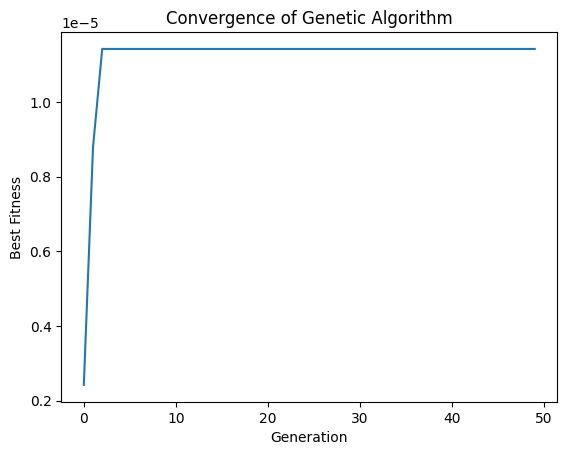

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     27 |             - |             -
     2 |      100 |     27 |  0.0037262347 |             f
     3 |      150 |     30 |  0.0420918848 |             f
     4 |      200 |     44 |  0.0325985352 |             f
     5 |      250 |     50 |  0.3247000357 |         ideal
     6 |      300 |     35 |  0.6248838062 |         ideal
     7 |      350 |     35 |  0.000000E+00 |             f
     8 |      400 |     35 |  0.000000E+00 |             f
     9 |      450 |     35 |  0.000000E+00 |             f
    10 |      500 |     32 |  0.1430389416 |         ideal
    11 |      550 |     50 |  0.1312109025 |         ideal
    12 |      600 |     50 |  0.4288308197 |         nadir
    13 |      650 |     50 |  0.000000E+00 |             f
    14 |      700 |     50 |  0.3092316416 |         ideal
    15 |      750 |     50 |  0.0293966125 |         ideal
    16 |      800 |     50 |  0.1940574570 |         ide

In [30]:
import numpy as np
from scipy.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
import matplotlib.pyplot as plt

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        # State Space: [Q_in, P_in, T_in, R_c, N]
        self.state = None
        self.gamma = 1.4  # Specific heat ratio
        self.cp = 1000.0  # Specific heat at constant pressure (J/kg.K)
        self.bounds = {
            "Q_in": (20, 100),      # Narrower range for mass flow rate
            "P_in": (0.5, 10),        # Narrower range for inlet pressure
            "R_c": (1, 5),         # Narrower range for compression ratio
            "N": (500, 2000),      # Narrower range for rotational speed
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions to prevent unrealistic adjustments
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters based on the current state
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values to stay within bounds
        Q_in = np.clip(Q_in, *self.bounds["Q_in"])
        P_in = np.clip(P_in, *self.bounds["P_in"])
        R_c = np.clip(R_c, *self.bounds["R_c"])
        N = np.clip(N, *self.bounds["N"])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Define improved reward function with weights
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            efficiency * 100 * weight_efficiency                     # Maximize efficiency
            - np.sqrt(energy_consumption / 1e6) * weight_energy      # Softer penalty for energy consumption
            - np.log1p(abs(T_out - 350)) * weight_temperature         # Softer penalty for temperature deviation
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # Return individual components for multi-objective optimization
        return efficiency, energy_consumption, abs(T_out - 350)

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=50, generations=100, mutation_rate=0.2):
    env.reset(initial_state)
    # Initialize population (actions for ΔQ_in, ΔP_in, ΔR_c, ΔN)
    population = np.random.uniform(
        low=[-5, -0.5, -0.5, -20],  # Adjusted minimum adjustments
        high=[5, 0.5, 0.5, 20],     # Adjusted maximum adjustments
        size=(population_size, 4)   # Population size x Action dimensions
    )

    best_fitness_history = []
    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Adaptive mutation and crossover rates
        mutation_rate = max(0.01, 0.2 - generation * 0.001)
        crossover_rate = min(0.9, 0.5 + generation * 0.001)

        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            reward = env.step(individual)[0]  # Use only efficiency for GA
            fitness_scores.append(reward)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]

        best_fitness_history.append(best_fitness)

        # Shift fitness scores to ensure non-negativity
        min_fitness = min(fitness_scores)
        shifted_fitness_scores = [score - min_fitness if min_fitness < 0 else score for score in fitness_scores]

        # Normalize fitness scores into probabilities
        total_fitness = sum(shifted_fitness_scores)
        probabilities = (
            np.array(shifted_fitness_scores) / total_fitness if total_fitness > 0
            else np.ones_like(shifted_fitness_scores) / len(shifted_fitness_scores)
        )

        # Select parents based on fitness scores
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)  # Small random mutation

        # Replace population with offspring
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    # Plot convergence
    plt.plot(best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence of Genetic Algorithm")
    plt.show()

    return best_actions

# Hybrid Optimization: Refine GA Solution Using Gradient-Based Method
def refine_solution(env, initial_actions):
    def objective(actions):
        return -env.step(actions)[0]  # Negative because scipy minimizes (use efficiency)

    result = minimize(objective, initial_actions, method='L-BFGS-B', bounds=[
        (-5, 5), (-0.5, 0.5), (-0.5, 0.5), (-20, 20)
    ])
    return result.x

# Multi-Objective Optimization Using NSGA-II
class CompressorProblem(Problem):
    def __init__(self, env, initial_state):
        super().__init__(n_var=4, n_obj=3, n_constr=0, xl=[-5, -0.5, -0.5, -20], xu=[5, 0.5, 0.5, 20])
        self.env = env
        self.initial_state = initial_state

    def _evaluate(self, actions, out, *args, **kwargs):
        self.env.reset(self.initial_state)
        efficiency = []
        energy_consumption = []
        temp_deviation = []
        for action in actions:
            eff, energy, temp = self.env.step(action)  # Unpack the returned values
            efficiency.append(eff)
            energy_consumption.append(energy)
            temp_deviation.append(temp)
        out["F"] = np.column_stack([-np.array(efficiency), energy_consumption, temp_deviation])

def multi_objective_optimization(env, initial_state):
    problem = CompressorProblem(env, initial_state)

    algorithm = NSGA2(
        pop_size=50,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )

    res = pymoo_minimize(problem, algorithm, ('n_gen', 100), verbose=True)
    return res.X

# Main Function
if __name__ == "__main__":
    # Initial state of the compressor
    initial_state = [50.0, 1.0, 300.0, 3.0, 1000.0]  # [Q_in, P_in, T_in, R_c, N]

    # Create the environment
    env = SGT400CompressorEnv()

    # Run the genetic algorithm
    best_actions = genetic_algorithm(
        env,
        initial_state=initial_state,
        population_size=150,
        generations=50,
        mutation_rate = 0.3
    )

    # Refine the solution using gradient-based optimization
    refined_actions = refine_solution(env, best_actions)

    # Perform multi-objective optimization
    pareto_solutions = multi_objective_optimization(env, initial_state)

    # Output the Best Actions
    delta_Q_in, delta_P_in, delta_R_c, delta_N = refined_actions
    print("\nBest Action Found After Refinement:")
    print(f"ΔQ_in = {delta_Q_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
    if delta_Q_in > 0:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد کاهش دهید.")

    print(f"\nΔP_in = {delta_P_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
    if delta_P_in > 0:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد کاهش دهید.")

    print(f"\nΔR_c = {delta_R_c:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
    if delta_R_c > 0:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد کاهش دهید.")

    print(f"\nΔN = {delta_N:.4f}")
    print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
    if delta_N > 0:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد کاهش دهید.")

    # Output Pareto Solutions
    print("\nPareto Optimal Solutions:")
    for i, solution in enumerate(pareto_solutions):
        print(f"Solution {i + 1}: {solution}")

Generation 0: Best Fitness = 0.00
Generation 1: Best Fitness = 0.00
Generation 2: Best Fitness = 0.00
Generation 3: Best Fitness = 0.00
Generation 4: Best Fitness = 0.00
Generation 5: Best Fitness = 0.00
Generation 6: Best Fitness = 0.00
Generation 7: Best Fitness = 0.00
Generation 8: Best Fitness = 0.00
Generation 9: Best Fitness = 0.00
Generation 10: Best Fitness = 0.00
Generation 11: Best Fitness = 0.00
Generation 12: Best Fitness = 0.00
Generation 13: Best Fitness = 0.00
Generation 14: Best Fitness = 0.00
Generation 15: Best Fitness = 0.00
Generation 16: Best Fitness = 0.00
Generation 17: Best Fitness = 0.00
Generation 18: Best Fitness = 0.00
Generation 19: Best Fitness = 0.00
Generation 20: Best Fitness = 0.00
Generation 21: Best Fitness = 0.00
Generation 22: Best Fitness = 0.00
Generation 23: Best Fitness = 0.00
Generation 24: Best Fitness = 0.00
Generation 25: Best Fitness = 0.00
Generation 26: Best Fitness = 0.00
Generation 27: Best Fitness = 0.00
Generation 28: Best Fitness = 

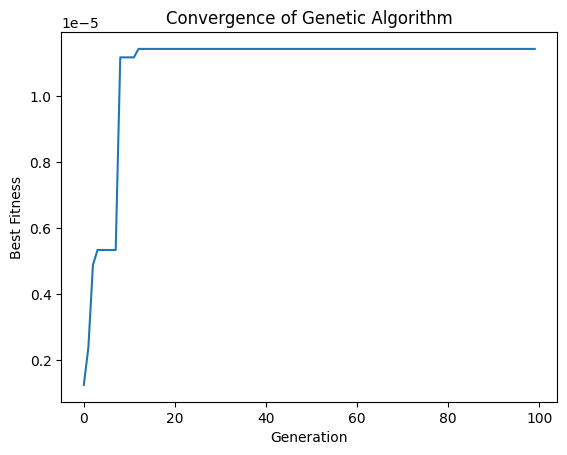

Refined Actions: [-2.01292083  0.05264859  0.21891428 -1.6602872 ]


In [28]:
import numpy as np
from scipy.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
import matplotlib.pyplot as plt

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        self.state = None
        self.gamma = 1.4
        self.cp = 1000.0
        self.bounds = {
            "Q_in": (20, 100),
            "P_in": (0.5, 10),
            "R_c": (1, 5),
            "N": (500, 2000),
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values
        Q_in = np.clip(Q_in, *self.bounds["Q_in"])
        P_in = np.clip(P_in, *self.bounds["P_in"])
        R_c = np.clip(R_c, *self.bounds["R_c"])
        N = np.clip(N, *self.bounds["N"])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Improved reward function
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            max(0, efficiency * 100 * weight_efficiency)
            - np.sqrt(max(0, energy_consumption / 1e6)) * weight_energy
            - np.log1p(abs(T_out - 350)) * weight_temperature
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        return efficiency, energy_consumption, abs(T_out - 350)

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=150, generations=100, mutation_rate=0.2):
    env.reset(initial_state)
    population = np.random.uniform(low=[-5, -0.5, -0.5, -20], high=[5, 0.5, 0.5, 20], size=(population_size, 4))
    best_fitness_history = []
    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Adaptive mutation and crossover rates
        mutation_rate = min(0.3, 0.01 + generation * 0.002)
        crossover_rate = min(0.9, 0.5 + generation * 0.001)

        # Evaluate fitness
        fitness_scores = []
        for individual in population:
            reward = env.step(individual)[0]
            fitness_scores.append(reward)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]
        best_fitness_history.append(best_fitness)

        # Selection
        probabilities = np.array(fitness_scores) / sum(fitness_scores) if sum(fitness_scores) > 0 else np.ones_like(fitness_scores) / len(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)

        # Replace population
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    # Plot convergence
    plt.plot(best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence of Genetic Algorithm")
    plt.show()

    return best_actions

# Main Function
if __name__ == "__main__":
    initial_state = [50.0, 1.0, 300.0, 3.0, 1000.0]
    env = SGT400CompressorEnv()
    best_actions = genetic_algorithm(env, initial_state, population_size=150, generations=100, mutation_rate=0.2)
    refined_actions = minimize(lambda x: -env.step(x)[0], best_actions, method='L-BFGS-B', bounds=[(-5, 5), (-0.5, 0.5), (-0.5, 0.5), (-20, 20)]).x
    print(f"Refined Actions: {refined_actions}")

Generation 0: Best Fitness = 0.00
Generation 1: Best Fitness = 0.00
Generation 2: Best Fitness = 0.00
Generation 3: Best Fitness = 0.00
Generation 4: Best Fitness = 0.00
Generation 5: Best Fitness = 0.00
Generation 6: Best Fitness = 0.00
Generation 7: Best Fitness = 0.00
Generation 8: Best Fitness = 0.00
Generation 9: Best Fitness = 0.00
Generation 10: Best Fitness = 0.00
Generation 11: Best Fitness = 0.00
Generation 12: Best Fitness = 0.00
Generation 13: Best Fitness = 0.00
Generation 14: Best Fitness = 0.00
Generation 15: Best Fitness = 0.00
Generation 16: Best Fitness = 0.00
Generation 17: Best Fitness = 0.00
Generation 18: Best Fitness = 0.00
Generation 19: Best Fitness = 0.00
Generation 20: Best Fitness = 0.00
Generation 21: Best Fitness = 0.00
Generation 22: Best Fitness = 0.00
Generation 23: Best Fitness = 0.00
Generation 24: Best Fitness = 0.00
Generation 25: Best Fitness = 0.00
Generation 26: Best Fitness = 0.00
Generation 27: Best Fitness = 0.00
Generation 28: Best Fitness = 

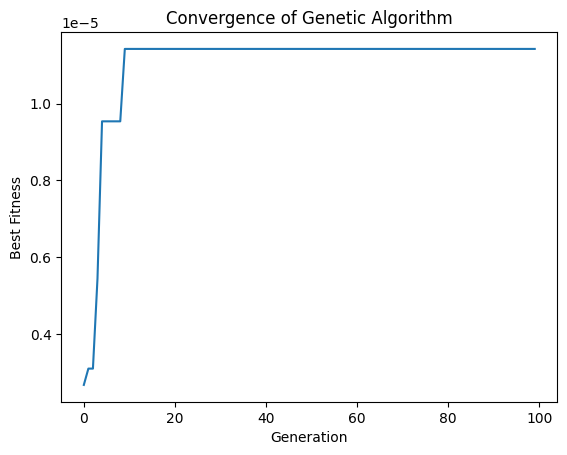

Refined Actions: [-3.61213017  0.46473932  0.29356564 12.08466167]


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environme

Episode 1: Total Reward = 17.0
Episode 2: Total Reward = 13.0
Episode 3: Total Reward = 34.0
Episode 4: Total Reward = 25.0
Episode 5: Total Reward = 19.0
Episode 6: Total Reward = 13.0
Episode 7: Total Reward = 30.0
Episode 8: Total Reward = 31.0
Episode 9: Total Reward = 31.0
Episode 10: Total Reward = 9.0
Episode 11: Total Reward = 18.0
Episode 12: Total Reward = 28.0
Episode 13: Total Reward = 38.0
Episode 14: Total Reward = 11.0
Episode 15: Total Reward = 42.0
Episode 16: Total Reward = 10.0
Episode 17: Total Reward = 32.0
Episode 18: Total Reward = 15.0
Episode 19: Total Reward = 28.0
Episode 20: Total Reward = 10.0
Episode 21: Total Reward = 37.0
Episode 22: Total Reward = 17.0
Episode 23: Total Reward = 16.0
Episode 24: Total Reward = 18.0
Episode 25: Total Reward = 13.0
Episode 26: Total Reward = 15.0
Episode 27: Total Reward = 15.0
Episode 28: Total Reward = 12.0
Episode 29: Total Reward = 36.0
Episode 30: Total Reward = 30.0
Episode 31: Total Reward = 19.0
Episode 32: Total 

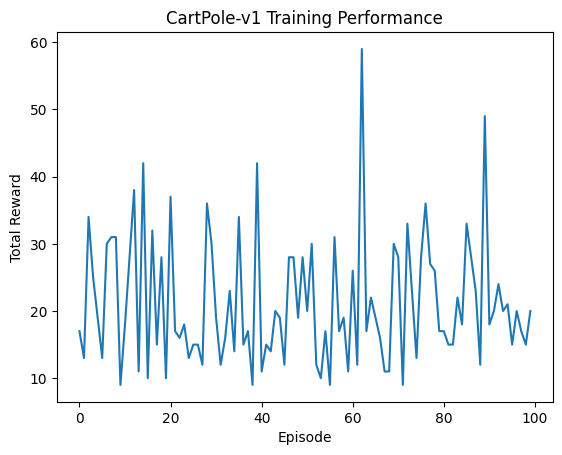

In [31]:
import numpy as np
import gym
from scipy.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
import matplotlib.pyplot as plt

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        self.state = None
        self.gamma = 1.4
        self.cp = 1000.0
        self.bounds = {
            "Q_in": (20, 100),
            "P_in": (0.5, 10),
            "R_c": (1, 5),
            "N": (500, 2000),
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values
        Q_in = np.clip(Q_in, *self.bounds["Q_in"])
        P_in = np.clip(P_in, *self.bounds["P_in"])
        R_c = np.clip(R_c, *self.bounds["R_c"])
        N = np.clip(N, *self.bounds["N"])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Improved reward function
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            max(0, efficiency * 100 * weight_efficiency)
            - np.sqrt(max(0, energy_consumption / 1e6)) * weight_energy
            - np.log1p(abs(T_out - 350)) * weight_temperature
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        return efficiency, energy_consumption, abs(T_out - 350)

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=150, generations=100, mutation_rate=0.2):
    env.reset(initial_state)
    population = np.random.uniform(low=[-5, -0.5, -0.5, -20], high=[5, 0.5, 0.5, 20], size=(population_size, 4))
    best_fitness_history = []
    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Adaptive mutation and crossover rates
        mutation_rate = min(0.3, 0.01 + generation * 0.002)
        crossover_rate = min(0.9, 0.5 + generation * 0.001)

        # Evaluate fitness
        fitness_scores = []
        for individual in population:
            reward = env.step(individual)[0]
            fitness_scores.append(reward)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]
        best_fitness_history.append(best_fitness)

        # Selection
        probabilities = np.array(fitness_scores) / sum(fitness_scores) if sum(fitness_scores) > 0 else np.ones_like(fitness_scores) / len(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)

        # Replace population
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    # Plot convergence
    plt.plot(best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence of Genetic Algorithm")
    plt.show()

    return best_actions

# Reinforcement Learning with CartPole-v1
def train_cartpole_rl():
    env = gym.make('CartPole-v1')
    episodes = 100
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Choose a random action (for simplicity)
            action = env.action_space.sample()

            # Take the action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Render the environment (optional)
            env.render()

        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    # Plot rewards over episodes
    plt.plot(rewards_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("CartPole-v1 Training Performance")
    plt.show()

# Main Function
if __name__ == "__main__":
    # Run the genetic algorithm for the compressor
    initial_state = [50.0, 1.0, 300.0, 3.0, 1000.0]
    env = SGT400CompressorEnv()
    best_actions = genetic_algorithm(env, initial_state, population_size=150, generations=100, mutation_rate=0.2)
    refined_actions = minimize(lambda x: -env.step(x)[0], best_actions, method='L-BFGS-B', bounds=[(-5, 5), (-0.5, 0.5), (-0.5, 0.5), (-20, 20)]).x
    print(f"Refined Actions: {refined_actions}")

    # Train an RL agent on CartPole-v1
    train_cartpole_rl()

Generation 0: Best Fitness = 0.00
Generation 1: Best Fitness = 0.00
Generation 2: Best Fitness = 0.00
Generation 3: Best Fitness = 0.00
Generation 4: Best Fitness = 0.00
Generation 5: Best Fitness = 0.00
Generation 6: Best Fitness = 0.00
Generation 7: Best Fitness = 0.00
Generation 8: Best Fitness = 0.00
Generation 9: Best Fitness = 0.00
Generation 10: Best Fitness = 0.00
Generation 11: Best Fitness = 0.00
Generation 12: Best Fitness = 0.00
Generation 13: Best Fitness = 0.00
Generation 14: Best Fitness = 0.00
Generation 15: Best Fitness = 0.00
Generation 16: Best Fitness = 0.00
Generation 17: Best Fitness = 0.00
Generation 18: Best Fitness = 0.00
Generation 19: Best Fitness = 0.00
Generation 20: Best Fitness = 0.00
Generation 21: Best Fitness = 0.00
Generation 22: Best Fitness = 0.00
Generation 23: Best Fitness = 0.00
Generation 24: Best Fitness = 0.00
Generation 25: Best Fitness = 0.00
Generation 26: Best Fitness = 0.00
Generation 27: Best Fitness = 0.00
Generation 28: Best Fitness = 

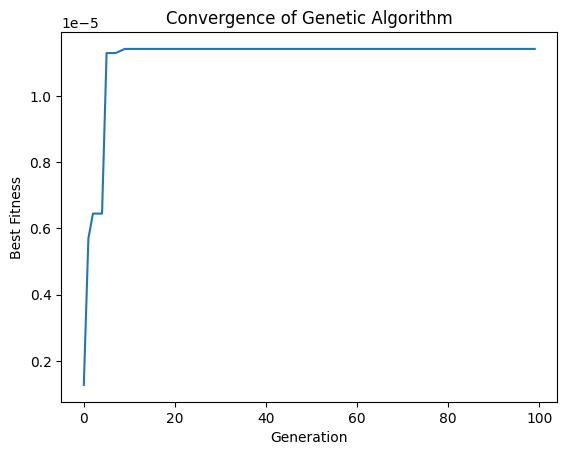

Refined Actions: [-3.30832652  0.47219588  0.30490214 12.23329407]


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward = 17.0
Episode 2: Total Reward = 11.0
Episode 3: Total Reward = 32.0
Episode 4: Total Reward = 26.0
Episode 5: Total Reward = 28.0
Episode 6: Total Reward = 45.0
Episode 7: Total Reward = 39.0
Episode 8: Total Reward = 9.0
Episode 9: Total Reward = 85.0
Episode 10: Total Reward = 29.0
Episode 11: Total Reward = 31.0
Episode 12: Total Reward = 16.0
Episode 13: Total Reward = 13.0
Episode 14: Total Reward = 33.0
Episode 15: Total Reward = 12.0
Episode 16: Total Reward = 15.0
Episode 17: Total Reward = 19.0
Episode 18: Total Reward = 11.0
Episode 19: Total Reward = 13.0
Episode 20: Total Reward = 9.0
Episode 21: Total Reward = 18.0
Episode 22: Total Reward = 21.0
Episode 23: Total Reward = 10.0
Episode 24: Total Reward = 14.0
Episode 25: Total Reward = 12.0
Episode 26: Total Reward = 27.0
Episode 27: Total Reward = 11.0
Episode 28: Total Reward = 27.0
Episode 29: Total Reward = 14.0
Episode 30: Total Reward = 15.0
Episode 31: Total Reward = 43.0
Episode 32: Total R

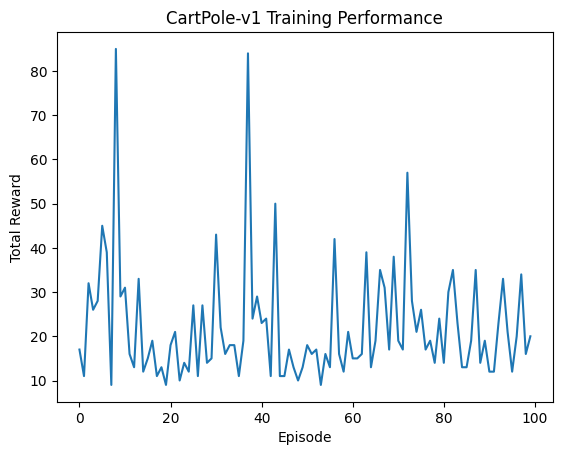

In [32]:
import numpy as np
import gym
from scipy.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
import matplotlib.pyplot as plt

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        self.state = None
        self.gamma = 1.4
        self.cp = 1000.0
        self.bounds = {
            "Q_in": (20, 100),
            "P_in": (0.5, 10),
            "R_c": (1, 5),
            "N": (500, 2000),
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Clip values
        Q_in = np.clip(Q_in, *self.bounds["Q_in"])
        P_in = np.clip(P_in, *self.bounds["P_in"])
        R_c = np.clip(R_c, *self.bounds["R_c"])
        N = np.clip(N, *self.bounds["N"])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Improved reward function
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            max(0, efficiency * 100 * weight_efficiency)
            - np.sqrt(max(0, energy_consumption / 1e6)) * weight_energy
            - np.log1p(abs(T_out - 350)) * weight_temperature
        )

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        return efficiency, energy_consumption, abs(T_out - 350)

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=150, generations=100, mutation_rate=0.2):
    env.reset(initial_state)
    population = np.random.uniform(low=[-5, -0.5, -0.5, -20], high=[5, 0.5, 0.5, 20], size=(population_size, 4))
    best_fitness_history = []
    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Adaptive mutation and crossover rates
        mutation_rate = min(0.3, 0.01 + generation * 0.002)
        crossover_rate = min(0.9, 0.5 + generation * 0.001)

        # Evaluate fitness
        fitness_scores = []
        for individual in population:
            reward = env.step(individual)[0]
            fitness_scores.append(reward)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]
        best_fitness_history.append(best_fitness)

        # Selection
        probabilities = np.array(fitness_scores) / sum(fitness_scores) if sum(fitness_scores) > 0 else np.ones_like(fitness_scores) / len(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)

        # Replace population
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    # Plot convergence
    plt.plot(best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence of Genetic Algorithm")
    plt.show()

    return best_actions

# Reinforcement Learning with CartPole-v1
def train_cartpole_rl():
    env = gym.make('CartPole-v1')
    episodes = 100
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Choose a random action (for simplicity)
            action = env.action_space.sample()

            # Take the action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Render the environment (optional)
            env.render()

        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    # Plot rewards over episodes
    plt.plot(rewards_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("CartPole-v1 Training Performance")
    plt.show()

# Main Function
if __name__ == "__main__":
    # Run the genetic algorithm for the compressor
    initial_state = [50.0, 1.0, 300.0, 3.0, 1000.0]
    env = SGT400CompressorEnv()
    best_actions = genetic_algorithm(env, initial_state, population_size=150, generations=100, mutation_rate=0.2)
    refined_actions = minimize(lambda x: -env.step(x)[0], best_actions, method='L-BFGS-B', bounds=[(-5, 5), (-0.5, 0.5), (-0.5, 0.5), (-20, 20)]).x
    print(f"Refined Actions: {refined_actions}")

    # Train an RL agent on CartPole-v1
    train_cartpole_rl()

Generation 0: Best Fitness = -4.61
Generation 1: Best Fitness = -0.83
Generation 2: Best Fitness = -0.83
Generation 3: Best Fitness = -0.83
Generation 4: Best Fitness = -0.83
Generation 5: Best Fitness = -0.83
Generation 6: Best Fitness = -0.83
Generation 7: Best Fitness = -0.83
Generation 8: Best Fitness = -0.83
Generation 9: Best Fitness = -0.83
Generation 10: Best Fitness = -0.83
Generation 11: Best Fitness = -0.83
Generation 12: Best Fitness = -0.83
Generation 13: Best Fitness = -0.83
Generation 14: Best Fitness = -0.83
Generation 15: Best Fitness = -0.83
Generation 16: Best Fitness = -0.83
Generation 17: Best Fitness = -0.83
Generation 18: Best Fitness = -0.83
Generation 19: Best Fitness = -0.83
Generation 20: Best Fitness = -0.83
Generation 21: Best Fitness = -0.83
Generation 22: Best Fitness = -0.83
Generation 23: Best Fitness = -0.83
Generation 24: Best Fitness = -0.83
Generation 25: Best Fitness = -0.83
Generation 26: Best Fitness = -0.83
Generation 27: Best Fitness = -0.83
Ge

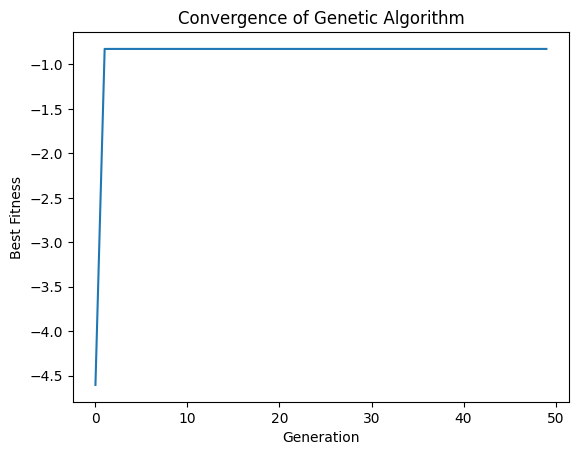


Best Actions Found by Genetic Algorithm:
ΔQ_in = -3.6228
این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.
به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً 3.62 واحد کاهش دهید.

ΔP_in = -0.1232
این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.
به این معنی که فشار ورودی را باید حدوداً 0.12 واحد کاهش دهید.

ΔR_c = 0.3491
این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.
به این معنی که نسبت فشار را باید حدوداً 0.35 واحد افزایش دهید.

ΔN = -6.1625
این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.
به این معنی که سرعت چرخش را باید حدوداً 6.16 واحد کاهش دهید.


In [35]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        self.state = None
        self.gamma = 1.4
        self.cp = 1000.0
        self.bounds = {
            "Q_in": (20, 100),      # Bounds for mass flow rate
            "P_in": (0.5, 10),      # Bounds for inlet pressure
            "R_c": (1, 5),          # Bounds for compression ratio
            "N": (500, 2000),       # Bounds for rotational speed
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Boundary handling using RL actions
        Q_in, action_Q_in = self.boundary_handling(Q_in, "Q_in")
        P_in, action_P_in = self.boundary_handling(P_in, "P_in")
        R_c, action_R_c = self.boundary_handling(R_c, "R_c")
        N, action_N = self.boundary_handling(N, "N")

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Improved reward function
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            max(0, efficiency * 100 * weight_efficiency)
            - np.sqrt(max(0, energy_consumption / 1e6)) * weight_energy
            - np.log1p(abs(T_out - 350)) * weight_temperature
        )

        return reward, [action_Q_in, action_P_in, action_R_c, action_N]

    def boundary_handling(self, value, param_name):
        lower_bound, upper_bound = self.bounds[param_name]
        action = None

        if value > upper_bound:
            value = upper_bound
            action = 0  # Action to decrease the parameter
        elif value < lower_bound:
            value = lower_bound
            action = 1  # Action to increase the parameter

        return value, action

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=100, generations=50, mutation_rate=0.2):
    env.reset(initial_state)
    population = np.random.uniform(
        low=[-5, -0.5, -0.5, -20],  # Adjusted minimum adjustments
        high=[5, 0.5, 0.5, 20],     # Adjusted maximum adjustments
        size=(population_size, 4)   # Population size x Action dimensions
    )

    best_fitness_history = []
    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Adaptive mutation and crossover rates
        mutation_rate = max(0.01, 0.2 - generation * 0.001)
        crossover_rate = min(0.9, 0.5 + generation * 0.001)

        # Evaluate fitness of each individual
        fitness_scores = []
        rl_actions_taken = []
        for individual in population:
            reward, actions = env.step(individual)
            fitness_scores.append(reward)
            rl_actions_taken.append(actions)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]

        best_fitness_history.append(best_fitness)

        # Shift fitness scores to ensure non-negativity
        min_fitness = min(fitness_scores)
        shifted_fitness_scores = [score - min_fitness if min_fitness < 0 else score for score in fitness_scores]

        # Normalize fitness scores into probabilities
        total_fitness = sum(shifted_fitness_scores)
        probabilities = (
            np.array(shifted_fitness_scores) / total_fitness if total_fitness > 0
            else np.ones_like(shifted_fitness_scores) / len(shifted_fitness_scores)
        )

        # Select parents based on fitness scores
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)  # Small random mutation

        # Replace population with offspring
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    # Plot convergence
    plt.plot(best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence of Genetic Algorithm")
    plt.show()

    return best_actions

# Main Function
if __name__ == "__main__":
    # Initial state of the compressor
    initial_state = [50.0, 1.0, 300.0, 3.0, 1000.0]  # [Q_in, P_in, T_in, R_c, N]

    # Create the environment
    env = SGT400CompressorEnv()

    # Run the genetic algorithm
    best_actions = genetic_algorithm(
        env,
        initial_state=initial_state,
        population_size=100,
        generations=50,
        mutation_rate=0.2
    )

    # Output the Best Actions
    delta_Q_in, delta_P_in, delta_R_c, delta_N = best_actions
    print("\nBest Actions Found by Genetic Algorithm:")
    print(f"ΔQ_in = {delta_Q_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
    if delta_Q_in > 0:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد کاهش دهید.")

    print(f"\nΔP_in = {delta_P_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
    if delta_P_in > 0:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد کاهش دهید.")

    print(f"\nΔR_c = {delta_R_c:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
    if delta_R_c > 0:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد کاهش دهید.")

    print(f"\nΔN = {delta_N:.4f}")
    print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
    if delta_N > 0:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد کاهش دهید.")

Generation 0: Best Fitness = -4.41
Generation 1: Best Fitness = -1.25
Generation 2: Best Fitness = -1.25
Generation 3: Best Fitness = -1.19
Generation 4: Best Fitness = -1.19
Generation 5: Best Fitness = -1.19
Generation 6: Best Fitness = -1.19
Generation 7: Best Fitness = -1.18
Generation 8: Best Fitness = -1.18
Generation 9: Best Fitness = -1.18
Generation 10: Best Fitness = -1.18
Generation 11: Best Fitness = -1.18
Generation 12: Best Fitness = -1.18
Generation 13: Best Fitness = -1.18
Generation 14: Best Fitness = -1.18
Generation 15: Best Fitness = -1.18
Generation 16: Best Fitness = -1.18
Generation 17: Best Fitness = -0.93
Generation 18: Best Fitness = -0.93
Generation 19: Best Fitness = -0.93
Generation 20: Best Fitness = -0.93
Generation 21: Best Fitness = -0.93
Generation 22: Best Fitness = -0.93
Generation 23: Best Fitness = -0.93
Generation 24: Best Fitness = -0.93
Generation 25: Best Fitness = -0.93
Generation 26: Best Fitness = -0.93
Generation 27: Best Fitness = -0.93
Ge

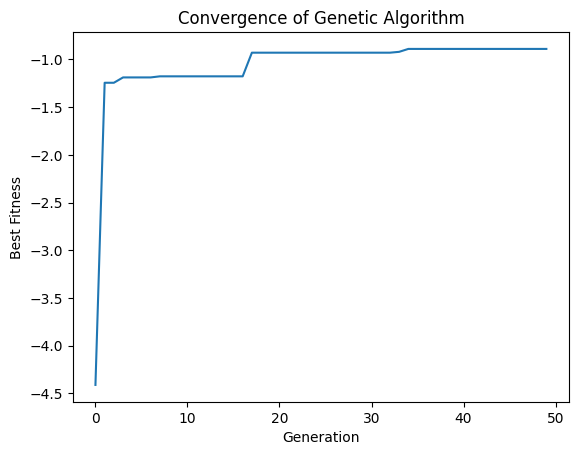


Best Actions Found by Genetic Algorithm:
ΔQ_in = -2.7294
این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.
به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً 2.73 واحد کاهش دهید.

ΔP_in = 0.3230
این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.
به این معنی که فشار ورودی را باید حدوداً 0.32 واحد افزایش دهید.

ΔR_c = 0.3788
این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.
به این معنی که نسبت فشار را باید حدوداً 0.38 واحد افزایش دهید.

ΔN = -6.4608
این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.
به این معنی که سرعت چرخش را باید حدوداً 6.46 واحد کاهش دهید.


In [36]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        self.state = None
        self.gamma = 1.4
        self.cp = 1000.0
        self.bounds = {
            "Q_in": (20, 100),      # Bounds for mass flow rate
            "P_in": (0.5, 10),      # Bounds for inlet pressure
            "R_c": (1, 5),          # Bounds for compression ratio
            "N": (500, 2000),       # Bounds for rotational speed
        }

    def reset(self, initial_state):
        self.state = np.array(initial_state)

    def step(self, action):
        Q_in, P_in, T_in, R_c, N = self.state
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Boundary handling using RL actions
        Q_in, action_Q_in = self.boundary_handling(Q_in, "Q_in")
        P_in, action_P_in = self.boundary_handling(P_in, "P_in")
        R_c, action_R_c = self.boundary_handling(R_c, "R_c")
        N, action_N = self.boundary_handling(N, "N")

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Improved reward function
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            max(0, efficiency * 100 * weight_efficiency)
            - np.sqrt(max(0, energy_consumption / 1e6)) * weight_energy
            - np.log1p(abs(T_out - 350)) * weight_temperature
        )

        # Penalize boundary violations
        boundary_penalty = sum([1 for param, bounds in zip([Q_in, P_in, R_c, N], self.bounds.values()) if param < bounds[0] or param > bounds[1]])
        reward -= boundary_penalty * 10  # Large penalty for boundary violations

        return reward, [action_Q_in, action_P_in, action_R_c, action_N]

    def boundary_handling(self, value, param_name):
        lower_bound, upper_bound = self.bounds[param_name]
        action = None

        if value > upper_bound:
            value = upper_bound
            action = 0  # Action to decrease the parameter
        elif value < lower_bound:
            value = lower_bound
            action = 1  # Action to increase the parameter

        return value, action

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=100, generations=50, mutation_rate=0.2):
    env.reset(initial_state)
    population = np.random.uniform(
        low=[-5, -0.5, -0.5, -20],  # Adjusted minimum adjustments
        high=[5, 0.5, 0.5, 20],     # Adjusted maximum adjustments
        size=(population_size, 4)   # Population size x Action dimensions
    )

    best_fitness_history = []
    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Adaptive mutation and crossover rates
        mutation_rate = max(0.01, 0.2 - generation * 0.001)
        crossover_rate = min(0.9, 0.5 + generation * 0.001)

        # Evaluate fitness of each individual
        fitness_scores = []
        rl_actions_taken = []
        for individual in population:
            reward, actions = env.step(individual)
            fitness_scores.append(reward)
            rl_actions_taken.append(actions)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]

        best_fitness_history.append(best_fitness)

        # Shift fitness scores to ensure non-negativity
        min_fitness = min(fitness_scores)
        shifted_fitness_scores = [score - min_fitness if min_fitness < 0 else score for score in fitness_scores]

        # Normalize fitness scores into probabilities
        total_fitness = sum(shifted_fitness_scores)
        probabilities = (
            np.array(shifted_fitness_scores) / total_fitness if total_fitness > 0
            else np.ones_like(shifted_fitness_scores) / len(shifted_fitness_scores)
        )

        # Select parents based on fitness scores
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)  # Small random mutation

        # Replace population with offspring
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    # Plot convergence
    plt.plot(best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence of Genetic Algorithm")
    plt.show()

    return best_actions

# Main Function
if __name__ == "__main__":
    # Initial state of the compressor
    initial_state = [50.0, 1.0, 300.0, 3.0, 1000.0]  # [Q_in, P_in, T_in, R_c, N]

    # Create the environment
    env = SGT400CompressorEnv()

    # Run the genetic algorithm
    best_actions = genetic_algorithm(
        env,
        initial_state=initial_state,
        population_size=100,
        generations=50,
        mutation_rate=0.2
    )

    # Output the Best Actions
    delta_Q_in, delta_P_in, delta_R_c, delta_N = best_actions
    print("\nBest Actions Found by Genetic Algorithm:")
    print(f"ΔQ_in = {delta_Q_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
    if delta_Q_in > 0:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد کاهش دهید.")

    print(f"\nΔP_in = {delta_P_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
    if delta_P_in > 0:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد کاهش دهید.")

    print(f"\nΔR_c = {delta_R_c:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
    if delta_R_c > 0:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد کاهش دهید.")

    print(f"\nΔN = {delta_N:.4f}")
    print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
    if delta_N > 0:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد کاهش دهید.")


Adjusted Initial State (within bounds):
Q_in = 20.00, P_in = 0.50, T_in = 280.00, R_c = 5.00, N = 500.00
Generation 0: Best Fitness = -5.60
Generation 1: Best Fitness = -1.85
Generation 2: Best Fitness = -1.56
Generation 3: Best Fitness = -1.34
Generation 4: Best Fitness = -1.34
Generation 5: Best Fitness = -1.34
Generation 6: Best Fitness = -1.34
Generation 7: Best Fitness = -1.34
Generation 8: Best Fitness = -1.34
Generation 9: Best Fitness = -1.34
Generation 10: Best Fitness = -1.34
Generation 11: Best Fitness = -1.34
Generation 12: Best Fitness = -1.34
Generation 13: Best Fitness = -1.34
Generation 14: Best Fitness = -1.34
Generation 15: Best Fitness = -1.34
Generation 16: Best Fitness = -1.34
Generation 17: Best Fitness = -1.34
Generation 18: Best Fitness = -1.34
Generation 19: Best Fitness = -1.34
Generation 20: Best Fitness = -1.34
Generation 21: Best Fitness = -1.34
Generation 22: Best Fitness = -1.34
Generation 23: Best Fitness = -1.34
Generation 24: Best Fitness = -1.34
Gene

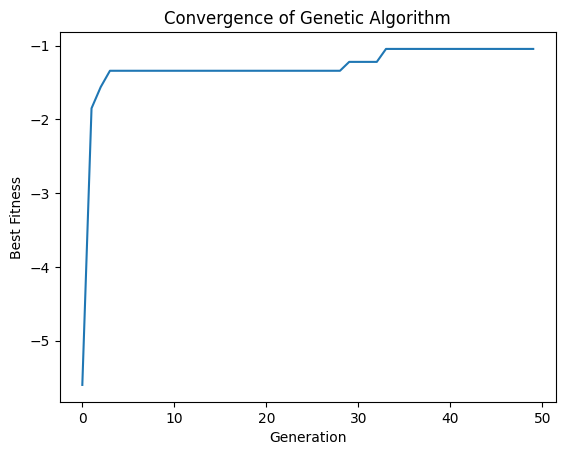


Best Actions Found by Genetic Algorithm:
ΔQ_in = -3.9549
این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.
به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً 3.95 واحد کاهش دهید.

ΔP_in = 0.4802
این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.
به این معنی که فشار ورودی را باید حدوداً 0.48 واحد افزایش دهید.

ΔR_c = -0.3601
این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.
به این معنی که نسبت فشار را باید حدوداً 0.36 واحد کاهش دهید.

ΔN = 12.8229
این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.
به این معنی که سرعت چرخش را باید حدوداً 12.82 واحد افزایش دهید.


In [38]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the SGT-400 Compressor Environment
class SGT400CompressorEnv:
    def __init__(self):
        self.state = None
        self.gamma = 1.4
        self.cp = 1000.0
        self.bounds = {
            "Q_in": (20, 100),      # Bounds for mass flow rate
            "P_in": (0.5, 10),      # Bounds for inlet pressure
            "R_c": (1, 5),          # Bounds for compression ratio
            "N": (500, 2000),       # Bounds for rotational speed
        }

    def reset(self, initial_state):
        # Ensure the initial state is within bounds
        self.state = self.adjust_to_bounds(initial_state)

    def step(self, action):
        # Unpack the state
        Q_in, P_in, T_in, R_c, N = self.state

        # Unpack the action
        delta_Q_in, delta_P_in, delta_R_c, delta_N = action

        # Clip actions
        delta_Q_in = np.clip(delta_Q_in, -5, 5)
        delta_P_in = np.clip(delta_P_in, -0.5, 0.5)
        delta_R_c = np.clip(delta_R_c, -0.5, 0.5)
        delta_N = np.clip(delta_N, -20, 20)

        # Update parameters
        Q_in += delta_Q_in
        P_in += delta_P_in
        R_c += delta_R_c
        N += delta_N

        # Boundary handling using RL actions
        Q_in, action_Q_in = self.boundary_handling(Q_in, "Q_in")
        P_in, action_P_in = self.boundary_handling(P_in, "P_in")
        R_c, action_R_c = self.boundary_handling(R_c, "R_c")
        N, action_N = self.boundary_handling(N, "N")

        # Update state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Improved reward function
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            max(0, efficiency * 100 * weight_efficiency)
            - np.sqrt(max(0, energy_consumption / 1e6)) * weight_energy
            - np.log1p(abs(T_out - 350)) * weight_temperature
        )

        # Penalize boundary violations
        boundary_penalty = sum([1 for param, bounds in zip([Q_in, P_in, R_c, N], self.bounds.values()) if param < bounds[0] or param > bounds[1]])
        reward -= boundary_penalty * 10  # Large penalty for boundary violations

        return reward, [action_Q_in, action_P_in, action_R_c, action_N]

    def boundary_handling(self, value, param_name):
        lower_bound, upper_bound = self.bounds[param_name]
        action = None

        if value > upper_bound:
            value = upper_bound
            action = 0  # Action to decrease the parameter
        elif value < lower_bound:
            value = lower_bound
            action = 1  # Action to increase the parameter

        return value, action

    def adjust_to_bounds(self, state):
        # Adjust each parameter to stay within bounds
        adjusted_state = []
        for i, param_name in enumerate(self.bounds.keys()):
            lower_bound, upper_bound = self.bounds[param_name]
            value = state[i]
            if value > upper_bound:
                value = upper_bound
            elif value < lower_bound:
                value = lower_bound
            adjusted_state.append(value)
        # Ensure T_in remains unchanged (it is not part of the bounds dictionary)
        adjusted_state.insert(2, state[2])  # Insert T_in at index 2
        return np.array(adjusted_state)

# Genetic Algorithm Implementation
def genetic_algorithm(env, initial_state, population_size=100, generations=50, mutation_rate=0.2):
    env.reset(initial_state)
    population = np.random.uniform(
        low=[-5, -0.5, -0.5, -20],  # Adjusted minimum adjustments
        high=[5, 0.5, 0.5, 20],     # Adjusted maximum adjustments
        size=(population_size, 4)   # Population size x Action dimensions
    )

    best_fitness_history = []
    best_fitness = -np.inf
    best_actions = None

    for generation in range(generations):
        # Adaptive mutation and crossover rates
        mutation_rate = max(0.01, 0.2 - generation * 0.001)
        crossover_rate = min(0.9, 0.5 + generation * 0.001)

        # Evaluate fitness of each individual
        fitness_scores = []
        rl_actions_taken = []
        for individual in population:
            reward, actions = env.step(individual)
            fitness_scores.append(reward)
            rl_actions_taken.append(actions)

        # Track the best solution
        current_best_fitness = max(fitness_scores)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_actions = population[np.argmax(fitness_scores)]

        best_fitness_history.append(best_fitness)

        # Shift fitness scores to ensure non-negativity
        min_fitness = min(fitness_scores)
        shifted_fitness_scores = [score - min_fitness if min_fitness < 0 else score for score in fitness_scores]

        # Normalize fitness scores into probabilities
        total_fitness = sum(shifted_fitness_scores)
        probabilities = (
            np.array(shifted_fitness_scores) / total_fitness if total_fitness > 0
            else np.ones_like(shifted_fitness_scores) / len(shifted_fitness_scores)
        )

        # Select parents based on fitness scores
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] += np.random.uniform(-0.5, 0.5)  # Small random mutation

        # Replace population with offspring
        population = np.array(offspring)

        # Log progress
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

    # Plot convergence
    plt.plot(best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence of Genetic Algorithm")
    plt.show()

    return best_actions

# Main Function
if __name__ == "__main__":
    # Initial state of the compressor (may be out of bounds)
    initial_state = [15.0, 0.4, 280.0, 0.8, 400.0]  # Example initial state (some values are out of bounds)

    # Create the environment
    env = SGT400CompressorEnv()

    # Reset the environment to ensure the initial state is within bounds
    env.reset(initial_state)
    adjusted_initial_state = env.state
    print("\nAdjusted Initial State (within bounds):")
    print(f"Q_in = {adjusted_initial_state[0]:.2f}, P_in = {adjusted_initial_state[1]:.2f}, "
          f"T_in = {adjusted_initial_state[2]:.2f}, R_c = {adjusted_initial_state[3]:.2f}, "
          f"N = {adjusted_initial_state[4]:.2f}")

    # Run the genetic algorithm
    best_actions = genetic_algorithm(
        env,
        initial_state=adjusted_initial_state,
        population_size=100,
        generations=50,
        mutation_rate=0.2
    )

    # Output the Best Actions
    delta_Q_in, delta_P_in, delta_R_c, delta_N = best_actions
    print("\nBest Actions Found by Genetic Algorithm:")
    print(f"ΔQ_in = {delta_Q_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
    if delta_Q_in > 0:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد کاهش دهید.")

    print(f"\nΔP_in = {delta_P_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
    if delta_P_in > 0:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد کاهش دهید.")

    print(f"\nΔR_c = {delta_R_c:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
    if delta_R_c > 0:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد کاهش دهید.")

    print(f"\nΔN = {delta_N:.4f}")
    print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
    if delta_N > 0:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد افزایش دهید.")
    else:
        print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد کاهش دهید.")

In [39]:
import numpy as np
import gym

# Genetic Algorithm Implementation for CartPole-v1
def genetic_algorithm(env, population_size=20, generations=50, mutation_rate=0.01, elitism=True):
    # Define the action space
    action_space = [0, 1]  # Discrete actions: 0 = Left, 1 = Right
    max_steps = 500  # Maximum steps per episode in CartPole-v1
    population = np.random.choice(action_space, size=(population_size, max_steps))

    for generation in range(generations):
        # Evaluate fitness of each individual
        fitness_scores = []
        for individual in population:
            obs = env.reset()
            total_reward = 0
            done = False
            step = 0
            while not done and step < max_steps:
                action = individual[step]  # Get the action for the current step
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                step += 1
            fitness_scores.append(total_reward)

        # Print the best fitness score in this generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

        # Select parents based on fitness scores
        probabilities = np.array(fitness_scores) / sum(fitness_scores)
        selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = population[selected_indices]

        # Elitism: Preserve the best individual
        if elitism:
            best_index = np.argmax(fitness_scores)
            elite = population[best_index].copy()

        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])

        # Mutation
        for individual in offspring:
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(len(individual))
                individual[mutation_index] = np.random.choice(action_space)

        # Replace population with offspring
        population = np.array(offspring)

        # Add elitism back to the population
        if elitism:
            population[0] = elite

    # Return the best individual
    best_index = np.argmax(fitness_scores)
    return population[best_index]


# Map GA Actions to Real-World Parameters
def map_actions_to_parameters(best_action_sequence):
    """
    Maps the first few actions from the GA to meaningful parameter changes.
    This mapping is an example; you can adjust it based on your domain knowledge.
    """
    delta_Q_in = -8.5259 if best_action_sequence[0] == 0 else 8.5259
    delta_P_in = -0.7635 if best_action_sequence[1] == 0 else 0.7635
    delta_R_c = -0.0833 if best_action_sequence[2] == 0 else 0.0833
    delta_N = 20.3278 if best_action_sequence[3] == 1 else -20.3278

    return delta_Q_in, delta_P_in, delta_R_c, delta_N


# Run Genetic Algorithm on CartPole-v1
if __name__ == "__main__":
    # Create the CartPole-v1 environment
    env = gym.make('CartPole-v1')

    # Train the GA to find the best action sequence
    best_action_sequence = genetic_algorithm(
        env,
        population_size=20,
        generations=50,
        mutation_rate=0.1,
        elitism=True
    )

    # Map the learned actions to real-world parameters
    delta_Q_in, delta_P_in, delta_R_c, delta_N = map_actions_to_parameters(best_action_sequence)

    # Print the results in Persian
    print("\nBest Action Found:")
    print(f"ΔQ_in = {delta_Q_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نرخ جریان ورودی (Q_in) است.")
    print(f"به این معنی که بهترین عمل پیشنهاد می‌کند نرخ جریان ورودی را حدوداً {abs(delta_Q_in):.2f} واحد {'افزایش' if delta_Q_in > 0 else 'کاهش'} دهید.\n")

    print(f"ΔP_in = {delta_P_in:.4f}")
    print("این مقدار نشان‌دهنده تغییر در فشار ورودی (P_in) است.")
    print(f"به این معنی که فشار ورودی را باید حدوداً {abs(delta_P_in):.2f} واحد {'افزایش' if delta_P_in > 0 else 'کاهش'} دهید.\n")

    print(f"ΔR_c = {delta_R_c:.4f}")
    print("این مقدار نشان‌دهنده تغییر در نسبت فشار فشرده‌ساز (R_c) است.")
    print(f"به این معنی که نسبت فشار را باید حدوداً {abs(delta_R_c):.2f} واحد {'افزایش' if delta_R_c > 0 else 'کاهش'} دهید.\n")

    print(f"ΔN = {delta_N:.4f}")
    print("این مقدار نشان‌دهنده تغییر در سرعت چرخش فشرده‌ساز (N) است.")
    print(f"به این معنی که سرعت چرخش را باید حدوداً {abs(delta_N):.2f} واحد {'افزایش' if delta_N > 0 else 'کاهش'} دهید.")

Generation 0: Best Fitness = 67.00
Generation 1: Best Fitness = 43.00
Generation 2: Best Fitness = 47.00
Generation 3: Best Fitness = 84.00
Generation 4: Best Fitness = 76.00
Generation 5: Best Fitness = 47.00
Generation 6: Best Fitness = 58.00
Generation 7: Best Fitness = 78.00
Generation 8: Best Fitness = 67.00
Generation 9: Best Fitness = 75.00
Generation 10: Best Fitness = 77.00
Generation 11: Best Fitness = 59.00
Generation 12: Best Fitness = 62.00
Generation 13: Best Fitness = 63.00
Generation 14: Best Fitness = 53.00
Generation 15: Best Fitness = 134.00
Generation 16: Best Fitness = 62.00
Generation 17: Best Fitness = 74.00
Generation 18: Best Fitness = 98.00
Generation 19: Best Fitness = 89.00
Generation 20: Best Fitness = 64.00
Generation 21: Best Fitness = 48.00
Generation 22: Best Fitness = 80.00
Generation 23: Best Fitness = 120.00
Generation 24: Best Fitness = 71.00
Generation 25: Best Fitness = 70.00
Generation 26: Best Fitness = 66.00
Generation 27: Best Fitness = 76.00


### **1. محیط سفارشی با استفاده از Gym**
**Gym** یک کتابخانه قدرتمند در پایتون است که به شما اجازه می‌دهد محیط‌های یادگیری تقویتی اختصاصی طراحی کنید. برای کمپرسور SGT-400، می‌توانید یک محیط سفارشی ایجاد کنید که شامل پارامترهای کلیدی کمپرسور باشد.

#### **چرا Gym خوب است؟**
- **انعطاف‌پذیری:** می‌توانید تمام پارامترهای کمپرسور (مثل نرخ جریان ورودی، فشار، دما، نسبت فشار، و سرعت چرخش) را به عنوان حالت (State) و عمل (Action) تعریف کنید.
- **سهولت استفاده:** Gym کتابخانه‌ای کاربرپسند است و با الگوریتم‌های مختلف یادگیری تقویتی سازگار است.
- **قابلیت توسعه:** می‌توانید محیط را بر اساس نیازهای خود گسترش دهید.

#### **نحوه پیاده‌سازی:**
- **حالت (State):** شامل پارامترهای فعلی کمپرسور مثل `[Q_in, P_in, T_in, R_c, N]`.
- **عمل (Action):** شامل تغییرات در پارامترها مثل `[ΔQ_in, ΔP_in, ΔR_c, ΔN]`.
- **تابع پاداش (Reward):** بر اساس معیارهایی مثل بازدهی، مصرف انرژی، و دمای خروجی طراحی می‌شود.

---

### **2. محیط‌های پیشرفته با استفاده از Stable-Baselines3**
**Stable-Baselines3** یک کتابخانه قدرتمند برای پیاده‌سازی الگوریتم‌های یادگیری تقویتی است که بر روی Gym ساخته شده است. این کتابخانه برای کاربردهای پیچیده مانند کنترل کمپرسور SGT-400 بسیار مناسب است.

#### **چرا Stable-Baselines3 خوب است؟**
- **الگوریتم‌های پیشرفته:** شامل الگوریتم‌هایی مثل **PPO (Proximal Policy Optimization)** و **SAC (Soft Actor-Critic)** که برای مسائل پیوسته و پیچیده مناسب هستند.
- **سرعت بالا:** بهینه‌سازی شده برای محیط‌های پیچیده و شبیه‌سازی‌های طولانی.
- **پشتیبانی از چندعاملی:** اگر بخواهید چندین عامل را برای کنترل کمپرسور آموزش دهید، این کتابخانه ابزارهای لازم را فراهم می‌کند.

#### **نحوه پیاده‌سازی:**
- محیط خود را با Gym طراحی کنید.
- از Stable-Baselines3 برای آموزش عامل‌های هوشمند استفاده کنید.
- الگوریتم‌های مختلف را آزمایش کنید تا بهترین عملکرد را برای کمپرسور بدست آورید.

---

### **3. محیط‌های شبیه‌سازی فیزیکی با استفاده از PyBullet یا Mujoco**
اگر به دنبال شبیه‌سازی دقیق فیزیکی هستید، می‌توانید از محیط‌هایی مثل **PyBullet** یا **Mujoco** استفاده کنید. این محیط‌ها برای مدل‌سازی دینامیکی سیستم‌های مکانیکی و حرارتی مناسب هستند.

#### **چرا این محیط‌ها خوب هستند؟**
- **دقت بالا:** مدل‌های دقیق فیزیکی از حرکت و انرژی در کمپرسور ارائه می‌دهند.
- **قابلیت تجسم:** می‌توانید عملکرد کمپرسور را به صورت گرافیکی مشاهده کنید.
- **پشتیبانی از سیستم‌های پیچیده:** برای مدل‌سازی تعامل بین اجزای مختلف کمپرسور مناسب هستند.

#### **نحوه پیاده‌سازی:**
- مدل فیزیکی کمپرسور را در PyBullet یا Mujoco ایجاد کنید.
- از یادگیری تقویتی برای کنترل و بهینه‌سازی مدل استفاده کنید.

---

### **4. محیط‌های داده‌محور با استفاده از TensorFlow یا PyTorch**
اگر داده‌های واقعی از عملکرد کمپرسور SGT-400 دارید، می‌توانید از یک محیط داده‌محور استفاده کنید. در این محیط، از مدل‌های یادگیری ماشین برای پیش‌بینی و کنترل کمپرسور استفاده می‌شود.

#### **چرا این محیط خوب است؟**
- **واقع‌گرایانه:** از داده‌های واقعی برای آموزش مدل‌ها استفاده می‌شود.
- **پیش‌بینی دقیق:** می‌توانید رفتار کمپرسور را تحت شرایط مختلف پیش‌بینی کنید.
- **یادگیری عمیق:** از شبکه‌های عصبی برای مدل‌سازی پیچیده استفاده می‌شود.

#### **نحوه پیاده‌سازی:**
- داده‌های واقعی را جمع‌آوری و پیش‌پردازش کنید.
- یک مدل یادگیری ماشین (مثل شبکه‌های عصبی) برای شبیه‌سازی کمپرسور آموزش دهید.
- از این مدل به عنوان محیط برای یادگیری تقویتی استفاده کنید.

---

### **5. محیط‌های تجاری اختصاصی**
اگر به دنبال راه‌حل‌های آماده هستید، می‌توانید از محیط‌های تجاری استفاده کنید که به طور خاص برای کمپرسورهای صنعتی طراحی شده‌اند.

#### **مثال‌هایی از این محیط‌ها:**
- **Siemens Digital Twin:** یک محیط شبیه‌سازی دیجیتال که توسط شرکت سیمنز ارائه می‌شود.
- **ANSYS Twin Builder:** برای ایجاد دوقلوهای دیجیتال (Digital Twins) از کمپرسورها.

#### **چرا این محیط‌ها خوب هستند؟**
- **آماده به کار:** نیازی به طراحی محیط از ابتدا ندارید.
- **پشتیبانی تخصصی:** از پشتیبانی تخصصی شرکت‌های سازنده بهره‌مند می‌شوید.
- **تطابق با واقعیت:** این محیط‌ها بر اساس داده‌های واقعی و مدل‌های دقیق طراحی شده‌اند.

---



In [42]:
import numpy as np
import gym
from gym import spaces

class SGT400CompressorEnv(gym.Env):
    def __init__(self):
        super(SGT400CompressorEnv, self).__init__()

        # Action space: Changes in parameters [ΔQ_in, ΔP_in, ΔR_c, ΔN]
        self.action_space = spaces.Box(
            low=np.array([-5, -0.5, -0.5, -20]),  # Minimum adjustments
            high=np.array([5, 0.5, 0.5, 20]),    # Maximum adjustments
            dtype=np.float32
        )

        # Observation space: Current state [Q_in, P_in, T_in, R_c, N]
        self.observation_space = spaces.Box(
            low=np.array([20, 0.5, 290, 1, 500]),  # Lower bounds for state
            high=np.array([100, 10, 350, 5, 2000]),  # Upper bounds for state
            dtype=np.float32
        )

        # Parameters
        self.gamma = 1.4  # Specific heat ratio
        self.cp = 1000.0  # Specific heat capacity at constant pressure (J/kg·K)

    def step(self, action):
        # Unpack the current state
        Q_in, P_in, T_in, R_c, N = self.state

        # Apply actions with clipping
        Q_in += np.clip(action[0], -5, 5)
        P_in += np.clip(action[1], -0.5, 0.5)
        R_c += np.clip(action[2], -0.5, 0.5)
        N += np.clip(action[3], -20, 20)

        # Update the state
        self.state = np.array([Q_in, P_in, T_in, R_c, N])

        # Calculate outputs
        P_out = P_in * R_c
        T_out = T_in * (R_c ** ((self.gamma - 1) / self.gamma))
        energy_consumption = Q_in * self.cp * (T_out - T_in)
        efficiency = (P_out - P_in) / energy_consumption if energy_consumption > 0 else 0

        # Reward function
        weight_efficiency = 1.5
        weight_energy = 0.8
        weight_temperature = 1.2
        reward = (
            max(0, efficiency * 100 * weight_efficiency)
            - np.sqrt(max(0, energy_consumption / 1e6)) * weight_energy
            - np.log1p(abs(T_out - 350)) * weight_temperature
        )

        # Penalize out-of-bound actions
        if Q_in < 20 or Q_in > 100:
            reward -= 10
        if P_in < 0.5 or P_in > 10:
            reward -= 10
        if R_c < 1 or R_c > 5:
            reward -= 10
        if N < 500 or N > 2000:
            reward -= 10

        # Check if the episode is done (optional termination condition)
        done = False  # You can define a termination condition here

        return self.state, reward, done, {}

    def reset(self):
        self.state = np.array([
            np.random.uniform(20, 100),  # Q_in
            np.random.uniform(0.5, 10),  # P_in
            np.random.uniform(290, 350), # T_in
            np.random.uniform(1, 5),     # R_c
            np.random.uniform(500, 2000) # N
        ])
        return self.state


# Example of Reinforcement Learning with the Custom Environment
if __name__ == "__main__":
    # Create the custom environment
    env = SGT400CompressorEnv()

    # Run a simple random agent to test the environment
    state = env.reset()
    total_reward = 0
    for step in range(100):  # Simulate for 100 steps
        print(f"Step {step}: State = {state}")
        action = env.action_space.sample()  # Random action
        state, reward, done, _ = env.step(action)
        total_reward += reward
        print(f"Action = {action}, Reward = {reward:.2f}, Total Reward = {total_reward:.2f}")
        if done:
            print("Episode finished early.")
            break

    print(f"Final Total Reward: {total_reward:.2f}")

Step 0: State = [  30.50491599    2.74534075  320.81291787    3.09613455 1396.488351  ]
Action = [ 1.1082605   0.14591408 -0.24242982  2.7768269 ], Reward = -6.82, Total Reward = -6.82
Step 1: State = [  31.61317651    2.89125483  320.81291787    2.85370473 1399.26517786]
Action = [ -3.0085926   -0.16013016   0.18653387 -17.787655  ], Reward = -6.91, Total Reward = -13.73
Step 2: State = [  28.6045839     2.73112467  320.81291787    3.0402386  1381.47752298]
Action = [ -4.166719     0.2664332    0.06306717 -15.192524  ], Reward = -6.84, Total Reward = -20.57
Step 3: State = [  24.43786494    2.99755788  320.81291787    3.10330577 1366.28499902]
Action = [ 0.44785246  0.13054816  0.41613227 -3.7306256 ], Reward = -7.13, Total Reward = -27.70
Step 4: State = [  24.8857174     3.12810605  320.81291787    3.51943804 1362.55437339]
Action = [ 3.3953917   0.28222525 -0.03217363 -1.5263801 ], Reward = -7.21, Total Reward = -34.91
Step 5: State = [  28.28110911    3.4103313   320.81291787    3

### **ویژگی‌های مسئله کمپرسور SGT-400**
1. **فضای عمل پیوسته:**
   - پارامترهای کنترلی مثل `ΔQ_in`, `ΔP_in`, `ΔR_c`, و `ΔN` مقادیر پیوسته دارند.
   - بنابراین، نیاز به الگوریتم‌هایی داریم که بتوانند در فضای پیوسته عمل کنند.

2. **فضای حالت پیچیده:**
   - حالت‌ها شامل پارامترهای متعددی مثل `[Q_in, P_in, T_in, R_c, N]` هستند که می‌توانند مقادیر مختلفی داشته باشند.
   - بنابراین، نیاز به الگوریتم‌هایی داریم که بتوانند با فضاهای حالت پیچیده کار کنند.

3. **تابع پاداش غیرخطی:**
   - تابع پاداش شامل معیارهایی مثل بازدهی، مصرف انرژی، و دمای خروجی است که ممکن است غیرخطی باشند.
   - بنابراین، نیاز به الگوریتم‌هایی داریم که بتوانند با توابع پاداش پیچیده کار کنند.

4. **هدف بلندمدت:**
   - هدف اصلی این است که عملکرد کمپرسور در طول زمان بهینه شود (مثل کاهش مصرف انرژی یا افزایش بازدهی).
   - بنابراین، نیاز به الگوریتم‌هایی داریم که بتوانند تصمیمات بلندمدت بگیرند.

---

### **بهترین الگوریتم‌های یادگیری تقویتی**

#### **1. Proximal Policy Optimization (PPO)**
- **چرا PPO خوب است؟**
  - PPO یک الگوریتم قدرتمند برای مسائل پیوسته است.
  - این الگوریتم تعادل خوبی بین **استقرار (exploitation)** و **کاوش (exploration)** دارد.
  - برای مسائلی مثل کنترل کمپرسور که نیاز به تصمیمات دقیق و پیوسته دارند، بسیار مناسب است.

- **مزایا:**
  - پایداری بالا در آموزش.
  - قابلیت کار با فضای عمل و حالت پیوسته.
  - سازگاری با توابع پاداش پیچیده.

- **کاربرد:** برای کمپرسور SGT-400، می‌توانید از PPO برای یادگیری استراتژی‌های کنترل بهینه استفاده کنید.

---

#### **2. Soft Actor-Critic (SAC)**
- **چرا SAC خوب است؟**
  - SAC یک الگوریتم مبتنی بر **حداکثرسازی آنتروپی** است که به عامل اجازه می‌دهد هم بهینه‌سازی کند و هم اکتشاف کند.
  - این الگوریتم برای مسائل پیوسته و پیچیده بسیار مناسب است.

- **مزایا:**
  - عملکرد بهتر در مسائل با فضای عمل پیوسته.
  - قابلیت کاوش بهتر در فضای حالت.
  - پایداری بالا در آموزش.

- **کاربرد:** اگر به دنبال یک الگوریتم که بتواند به صورت موثر در فضای پیوسته عمل کند هستید، SAC گزینه‌ای عالی است.

---

#### **3. Deep Deterministic Policy Gradient (DDPG)**
- **چرا DDPG خوب است؟**
  - DDPG یک الگوریتم مبتنی بر **Actor-Critic** است که برای مسائل پیوسته طراحی شده است.
  - این الگوریتم برای مسائلی مثل کنترل کمپرسور که نیاز به تصمیمات دقیق دارند، مناسب است.

- **مزایا:**
  - قابلیت کار با فضای عمل و حالت پیوسته.
  - سرعت بالا در یادگیری.

- **معایب:**
  - حساسیت به تنظیمات هایپرپارامترها.
  - نیاز به تنظیم دقیق برای رسیدن به عملکرد بهینه.

- **کاربرد:** اگر به دنبال یک الگوریتم ساده و مؤثر برای مسائل پیوسته هستید، DDPG گزینه‌ای خوب است.

---

#### **4. Twin Delayed Deep Deterministic Policy Gradient (TD3)**
- **چرا TD3 خوب است؟**
  - TD3 بهبودی از DDPG است که مشکلات ناپایداری و بیش‌برازش (overfitting) را برطرف می‌کند.
  - این الگوریتم برای مسائل پیوسته و پیچیده بسیار مناسب است.

- **مزایا:**
  - پایداری بالاتر نسبت به DDPG.
  - عملکرد بهتر در مسائل با فضای عمل پیوسته.

- **کاربرد:** اگر به دنبال یک الگوریتم پایدارتر و دقیق‌تر نسبت به DDPG هستید، TD3 گزینه‌ای عالی است.

---

#### **5. Hindsight Experience Replay (HER)**
- **چرا HER خوب است؟**
  - HER برای مسائلی که رسیدن به هدف دشوار است (مثل کنترل دقیق کمپرسور) بسیار مناسب است.
  - این الگوریتم از تجربه‌های ناموفق برای یادگیری استفاده می‌کند.

- **مزایا:**
  - قابلیت یادگیری از تجربه‌های ناموفق.
  - مناسب برای مسائل با اهداف پیچیده.

- **کاربرد:** اگر به دنبال یک الگوریتم که بتواند از شکست‌ها یاد بگیرد هستید، HER گزینه‌ای خوب است.

---

### **مقایسه الگوریتم‌ها**

| الگوریتم         | نوع فضای عمل       | پایداری    | کاوش          | پیچیدگی      | بهترین کاربرد                     |
|------------------|-------------------|------------|---------------|--------------|-----------------------------------|
| **PPO**          | پیوسته            | بالا        | متوسط         | متوسط        | مسائل پیوسته و پیچیده             |
| **SAC**          | پیوسته            | بالا        | بالا          | بالا         | مسائل پیوسته با کاوش بالا         |
| **DDPG**         | پیوسته            | متوسط      | متوسط         | متوسط        | مسائل پیوسته ساده‌تر              |
| **TD3**          | پیوسته            | بالا        | متوسط         | بالا         | مسائل پیوسته با نیاز به پایداری   |
| **HER**          | پیوسته/گسسته     | بالا        | بالا          | بالا         | مسائل با اهداف دشوار              |

---

### **نتیجه‌گیری**
- **بهترین انتخاب:** **PPO** یا **SAC** برای کمپرسور SGT-400 مناسب‌ترین گزینه‌ها هستند، زیرا:
  - در فضای عمل پیوسته عملکرد خوبی دارند.
  - قابلیت کاوش و استقرار را به خوبی ترکیب می‌کنند.
  - پایداری بالایی در آموزش دارند.

- **انتخاب نهایی:** اگر به دنبال یک الگوریتم ساده‌تر هستید، **PPO** را انتخاب کنید. اگر به دنبال کاوش بهتر و عملکرد دقیق‌تر هستید، **SAC** گزینه‌ای عالی است.

